<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Macros/DeadTimeEstimatorMDC2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init and cuts definition

In [1]:
!pip install hist
!pip install mplhep
import hist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

#h5fileCE='drive/MyDrive/root_files_cry5/trk.mu2e.CeEndpointMix1BBSignal.MDC2020r_perfect_v1_0.h5'
h5fileCE='drive/MyDrive/root_files_cry5/trk.mu2e.CeEndpointMix2BBSignal.MDC2020r_perfect_v1_0.h5'
h5fileCRY5='drive/MyDrive/root_files_cry5/trk.mu2e.CosmicCRYOnSpillSignal.MDC2020r_perfect_v1_0.h5'

# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/MyDrive/'
except:
    main_path = ''
sys.path.append(main_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import mplhep as hep
hep.style.use('ATLAS')  # or ATLAS/LHCb2

In [4]:
!pip install -I git+https://github.com/oksuzian/mu2etools.git
from mu2etools import utils, cuts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/oksuzian/mu2etools.git to /tmp/pip-req-build-4xnbiqv6
  Running command git clone -q https://github.com/oksuzian/mu2etools.git /tmp/pip-req-build-4xnbiqv6
  Created wheel for mu2etools: filename=mu2etools-0.0.1-py3-none-any.whl size=5995 sha256=e1bdb93cbb5dc69d449f32a0ab8169c3e6671939101714cd17d979c8306fcd09
  Stored in directory: /tmp/pip-ephem-wheel-cache-rb2v06bf/wheels/00/92/a8/d2a2c55928a20d8675652a7135b8880f1f4f9b655d8885d452
Successfully built mu2etools


In [56]:
TMIN = -160
TMAX = 140
PMIN_EXT = 90
PMAX_EXT = 140
PMIN_PHY = 103.85
PMAX_PHY = 105.1

#Default MDC-style cut box
cuts = [
    "(de_status > 0)",
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 105)",
    "(deent_maxr > 450)",
    "(deent_maxr < 680)"
]
cut_tbox = " & ".join(cuts)

#PID, TrkQual and cut on events with an usptream leg
cuts = [
    "(dequal_TrkQual > 0.8)",
    "(dequal_TrkPID > 0.95)",
    "(ue_status <= 0)"
]
cut_pid_trkqual_ue = " & ".join(cuts)

# Extended momentum window cut`
cuts = [
    "(deent_mom > %f)" % PMIN_EXT,
    "(deent_mom < %f)" % PMAX_EXT
]
cut_extmom = " & ".join(cuts)

# Physics momentum window cut`
cuts = [
    "(deent_mom > %f)" % PMIN_PHY,
    "(deent_mom < %f)" % PMAX_PHY,
]
cut_phymom = " & ".join(cuts)

# Loose box cuts
cuts = [
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 205)",
    "(deent_maxr > 450)"
]
cut_lbox = " & ".join(cuts)

cut_t0='(de_t0 > 650) & (de_t0 < 1625)'
crv_live_window='((crvinfo_timeWindowStart > 475 & crvinfo_timeWindowStart < 1650) | crvinfo_timeWindowStart<1)'
# Outside of the coincidence time window
crv_time = "(de_t0 < crvinfo_timeWindowStart + %d | de_t0 > crvinfo_timeWindowEnd + %d)" % (TMIN, TMAX)
# Outside of the coincidence angular window
crv_angle = "(crvinfo_angle < %d | crvinfo_angle > %d)" % (-2.5, 2.5)


#crv_time = "(crvinfo_dTe < %d | crvinfo_dTe > %d)" % (TMIN, TMAX)
#crv_time = crv_time+"& ( crvinfo_dTe < %d | crvinfo_dTe > %d)" % (-100, 150)
#crv_time = crv_time+"& (de_t0 < crvinfo_timeWindowStart | de_t0> crvinfo_timeWindowEnd)" 
#Combime cuts
cut_nomom  = cut_tbox +" & "+cut_pid_trkqual_ue
cut_extmom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_extmom
cut_phymom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_phymom
cut_loose  = cut_lbox +" & "+cut_pid_trkqual_ue

cut_extmom_notiming = cut_extmom
#cut_extmom = cut_extmom+" & " + cut_t0+" & " + crv_live_window
#cut_current = cut_extmom+" & ("+crv_time+" | "+crv_angle+")"
cut_current = cut_extmom+" & "+crv_time

#Load dataframe

In [6]:
dfCRY5 = pd.read_hdf(h5fileCRY5, mode='r').query('lyield==%i' % 17000)
dfCE = pd.read_hdf(h5fileCE, mode='r', key='CE2B').query('lyield==%i' % 17000)

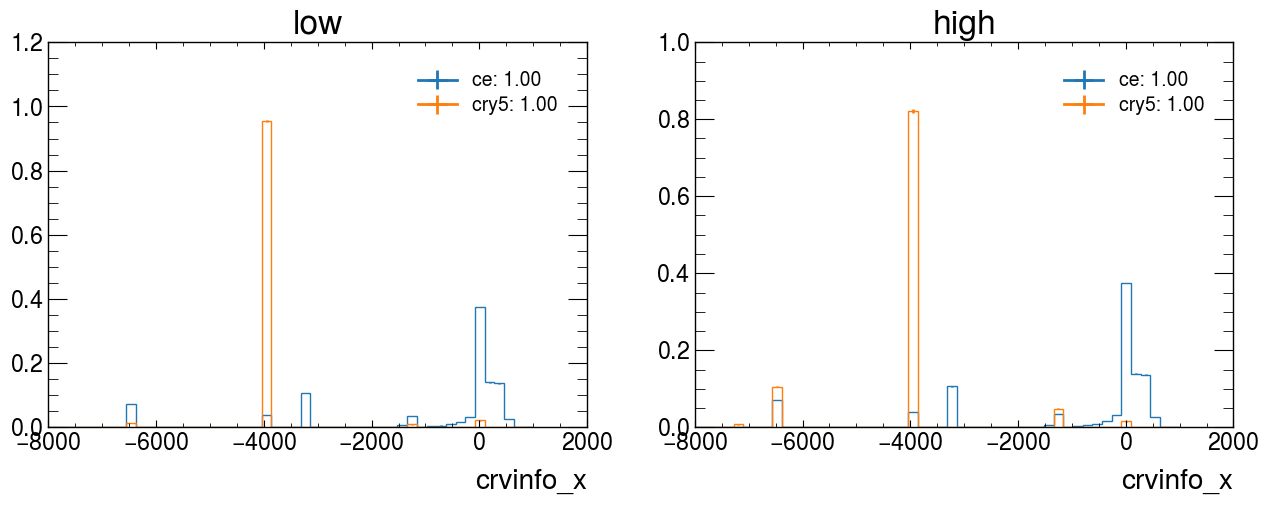

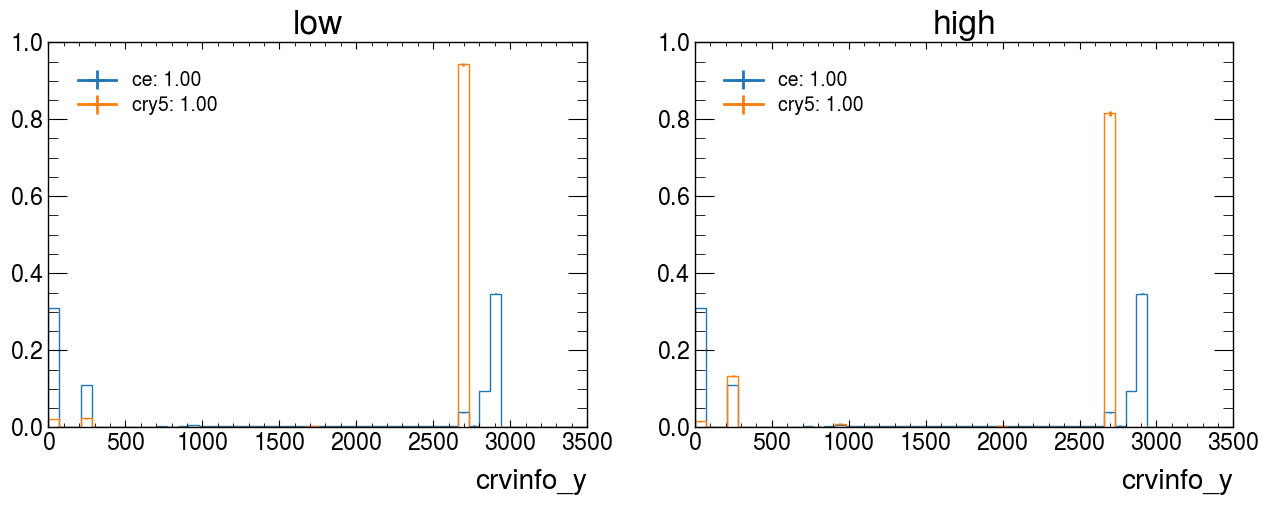

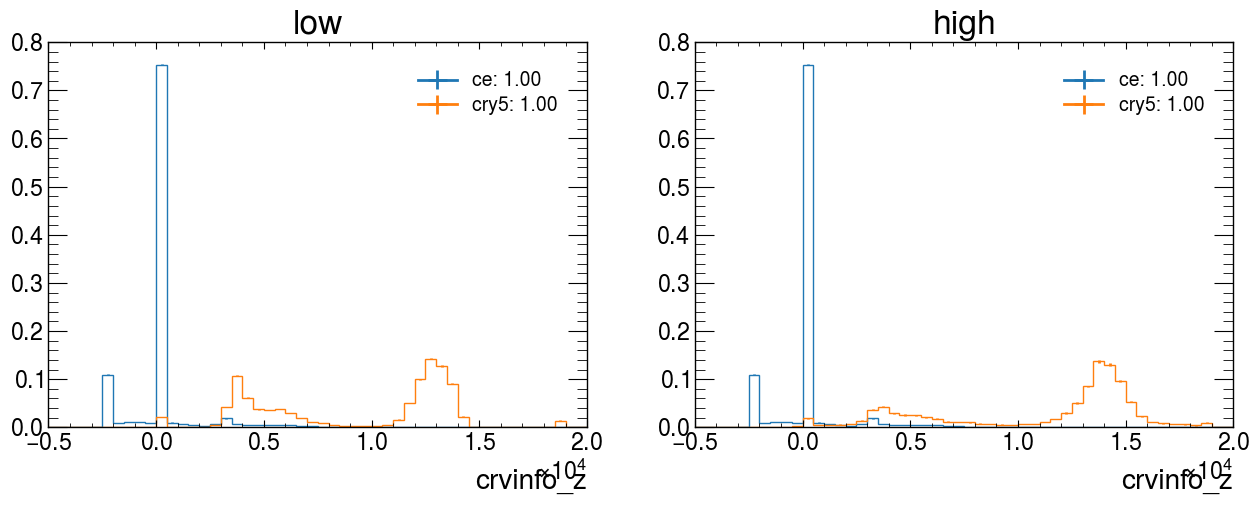

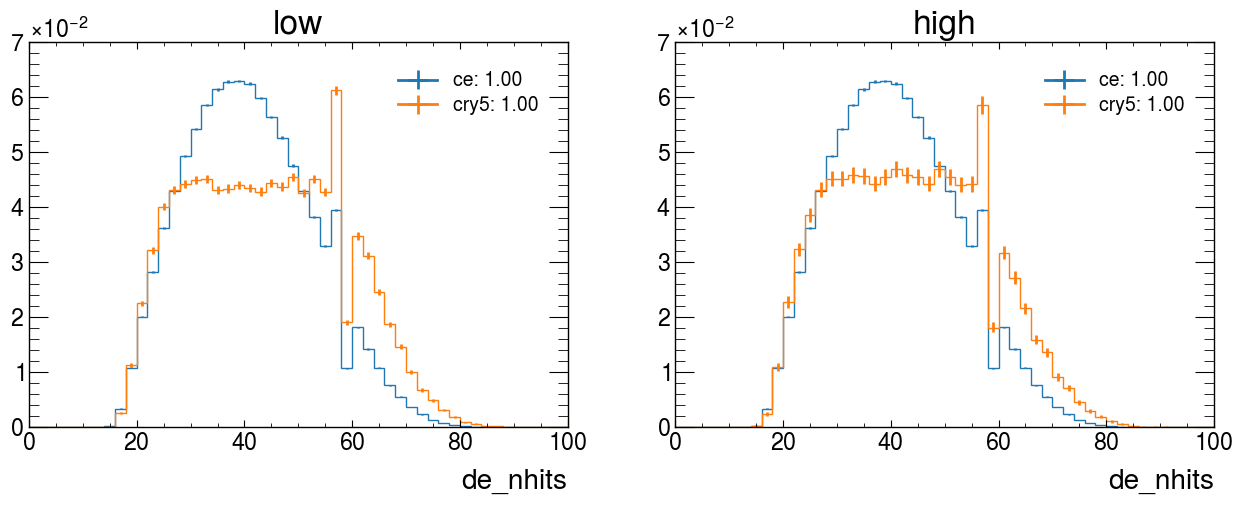

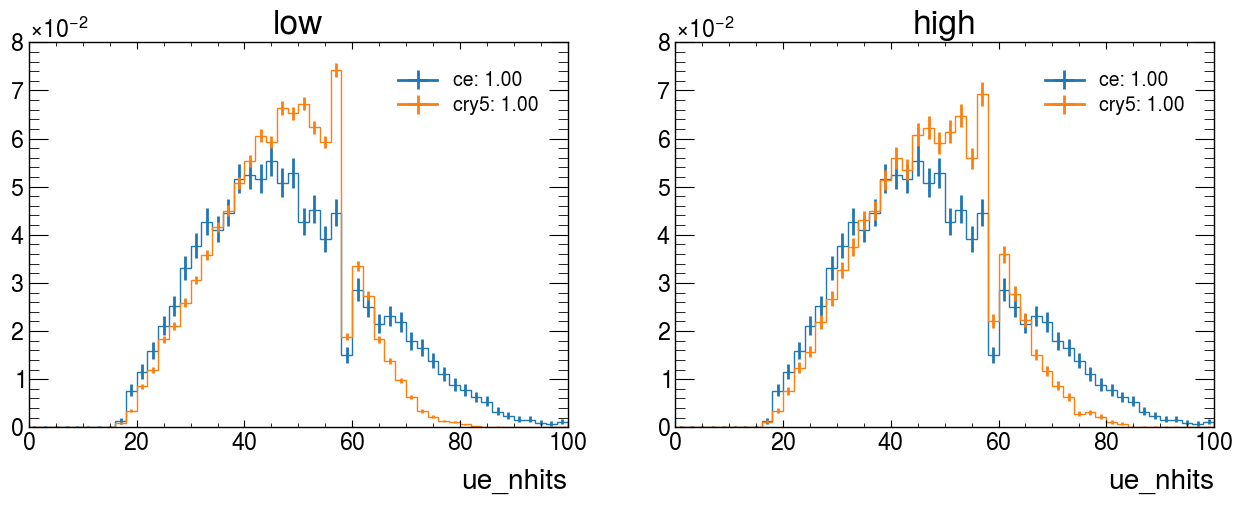

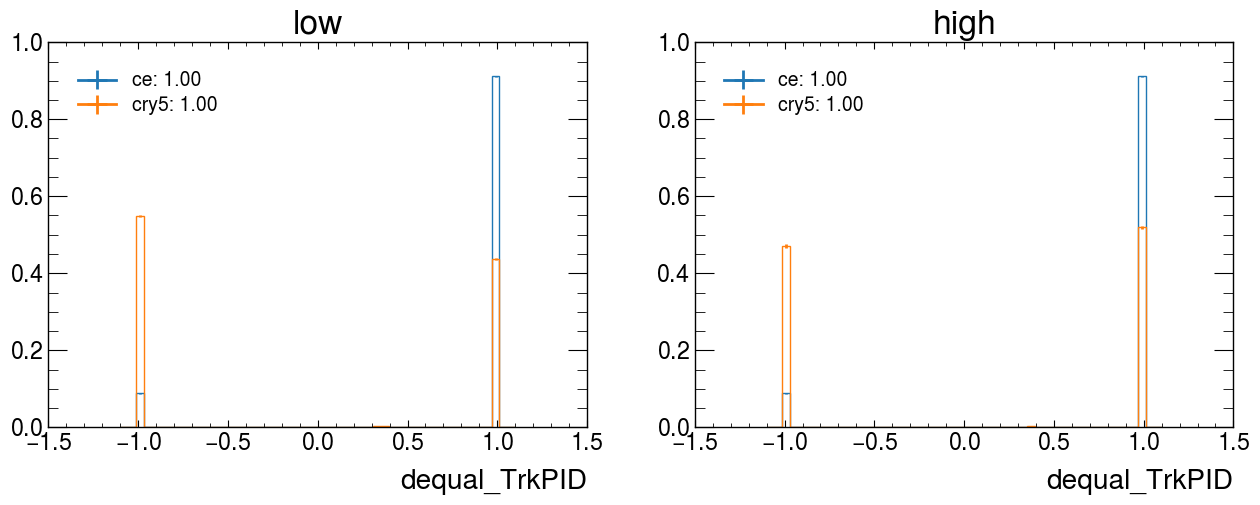

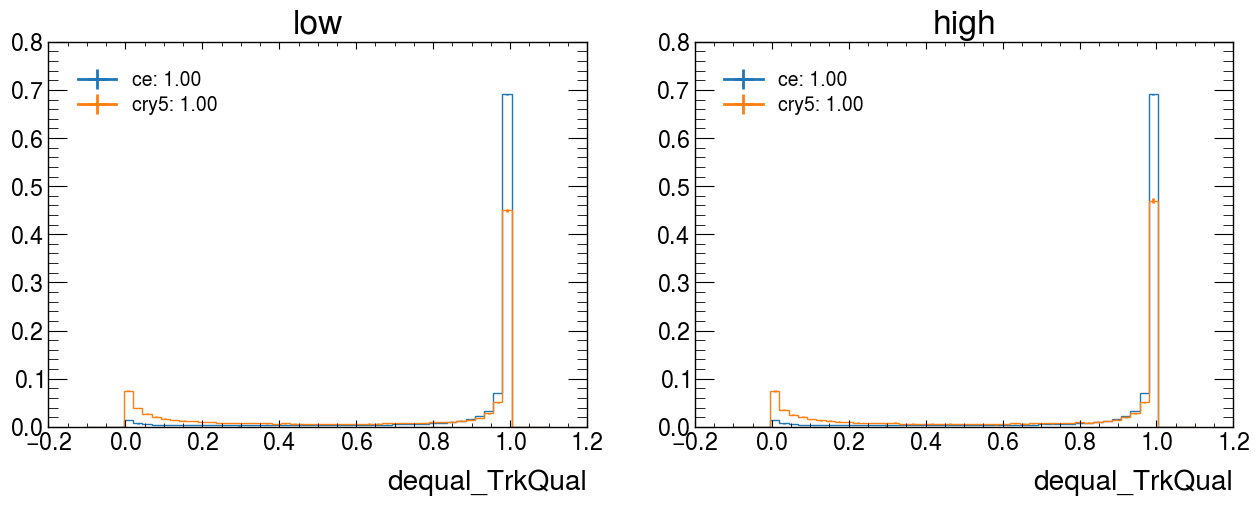

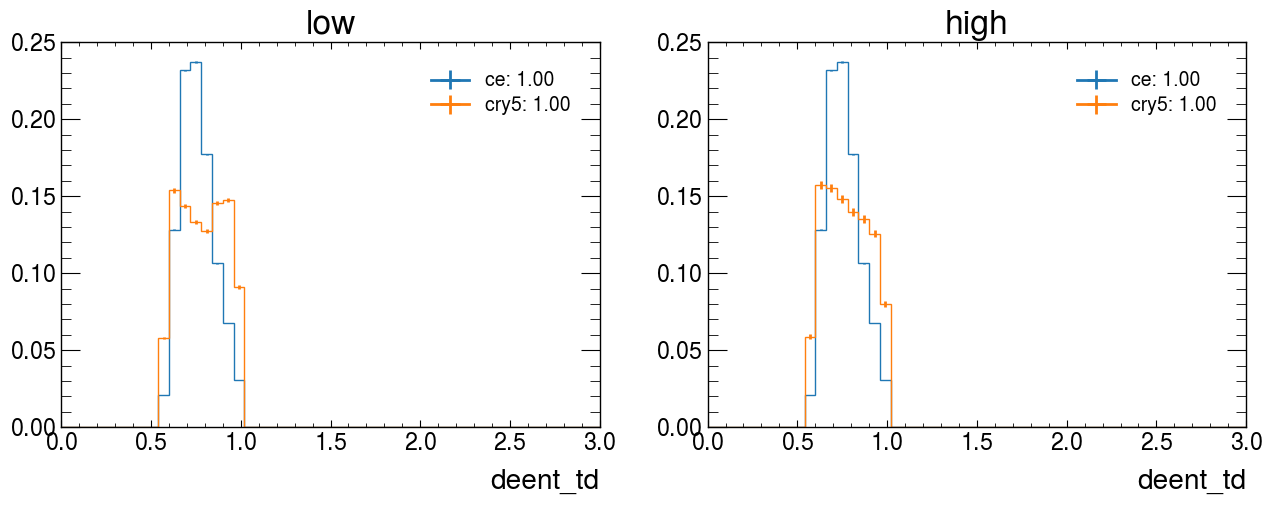

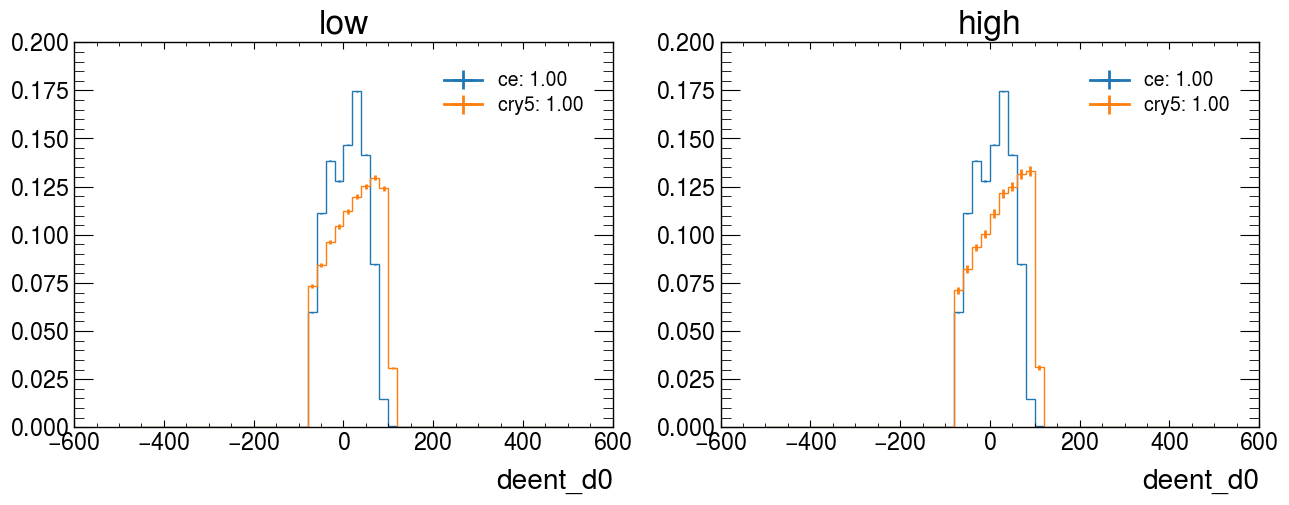

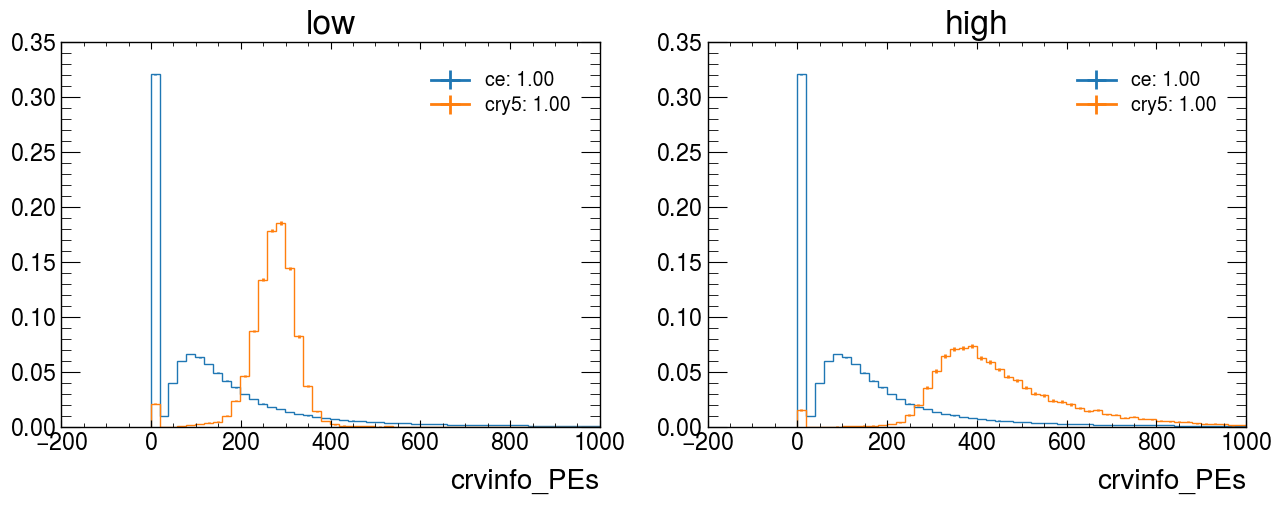

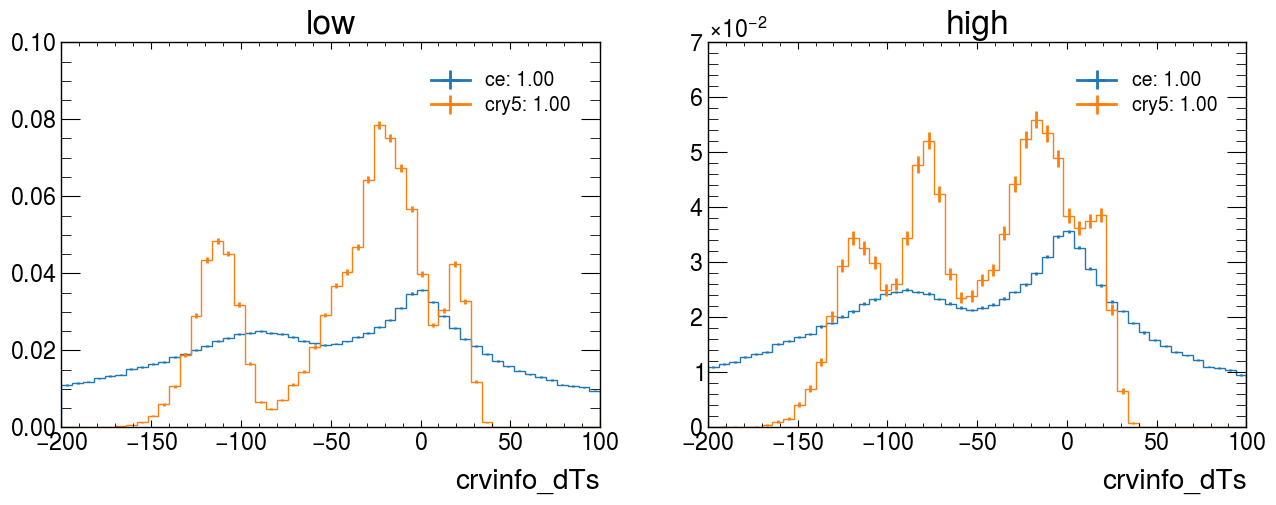

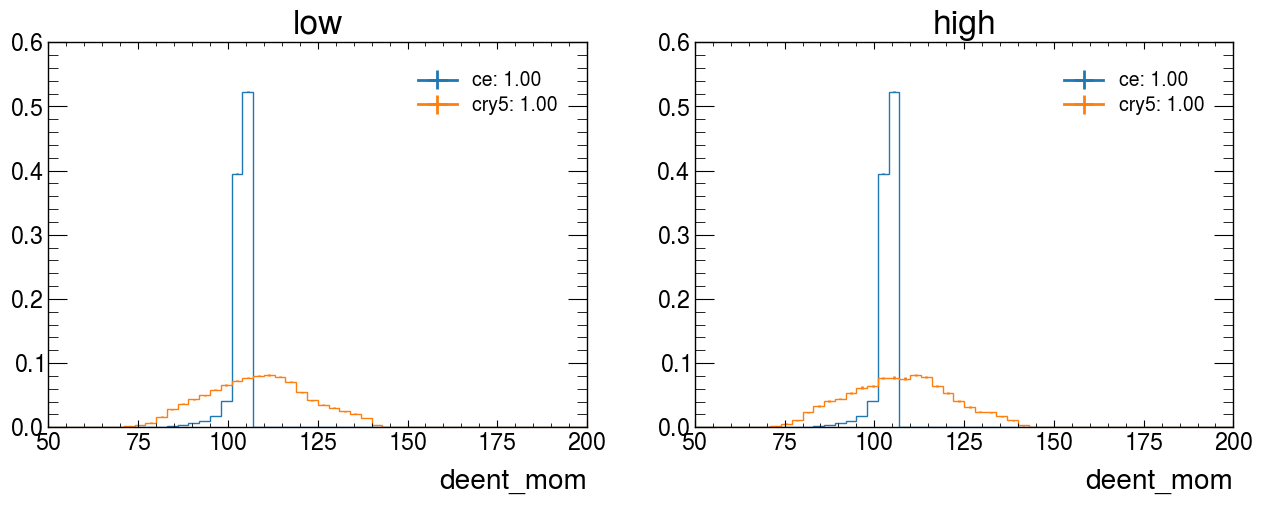

In [7]:
var_dict = utils.getVarList('allCRY5')

utils.LIVETIME_LO_CRY5 = 1.15E8*780/907
utils.LIVETIME_HI_CRY5 = 3.83E6*190/323

nLTimesCRY5 = [utils.LIVETIME_LO_CRY5/utils.LIVETIME_MU2E, utils.LIVETIME_HI_CRY5/utils.LIVETIME_MU2E]

title=["low", "high"]

for var in var_dict.keys():
  if "deent_z0" in var or "deent_om" in var: 
    continue

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
  h = hist.Hist(
    hist.axis.StrCategory(["ce", "cry5"], name="cat"),
    hist.axis.Regular(50, var_dict[var][0], var_dict[var][1], name="x", label="w [units]"),
    hist.storage.Weight(),
  ) 

  cut_tmp='(deent_mom > 100) & (deent_mom < 110)'
  for i in [0,1]:
    h.reset()
    h.fill(cat="ce", x=dfCE.query(cut_tbox + '& is_high==-1')[var].to_numpy())
    h.fill(cat="cry5", x=dfCRY5.query(cut_tbox + '& is_high==%d'%i)[var].to_numpy())

    h_tmp=(h["ce", :] / h["ce", :].counts().sum())
    h_tmp.plot(ax=axes[i], label='ce: %.2f'%h_tmp.counts().sum())
    h_tmp=(h["cry5", :] / h["cry5", :].counts().sum())
    h_tmp.plot(ax=axes[i], label='cry5: %.2f'%h_tmp.counts().sum())

    axes[i].set_xlabel(var)
    axes[i].set_title(title[i])
    axes[i].legend()


#Background estimation: production sources

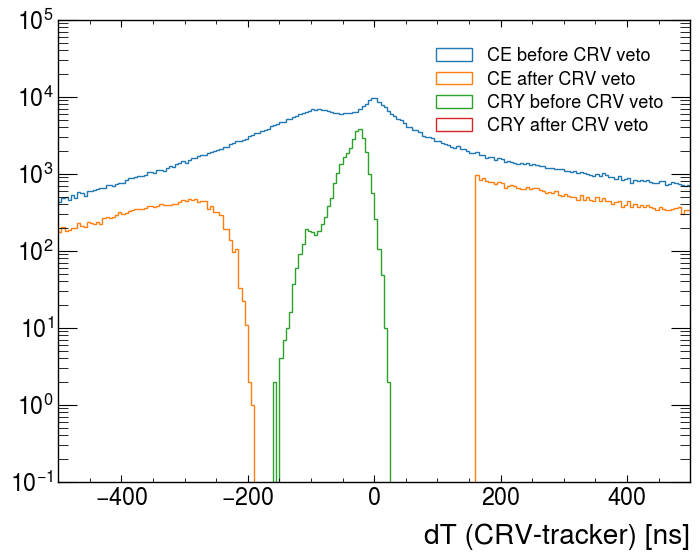

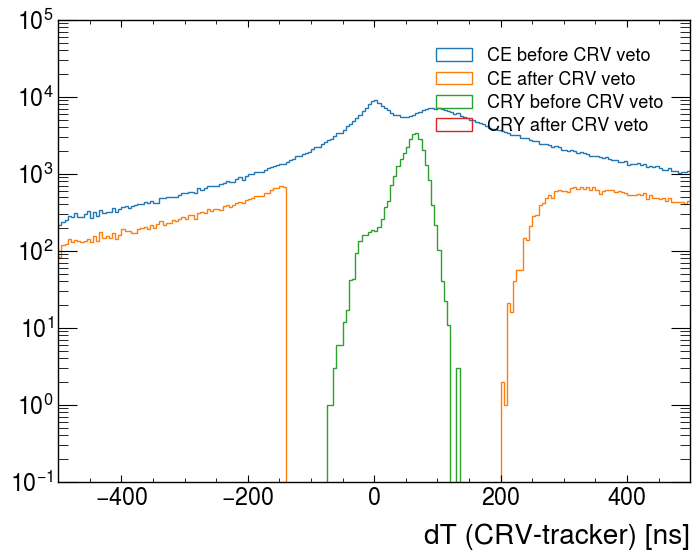

In [8]:
plt.hist(dfCE.query(cut_extmom+'& crvinfo_timeWindowStart>0')['crvinfo_dTs'], bins=400, range=(-1000, 1000), histtype='step', label='CE before CRV veto');
plt.hist(dfCE.query(cut_current+'& crvinfo_timeWindowStart>0')['crvinfo_dTs'], bins=400, range=(-1000, 1000), histtype='step', label='CE after CRV veto');
plt.hist(dfCRY5.query(cut_extmom+'& crvinfo_timeWindowStart>0')['crvinfo_dTs'], histtype='step', bins=400, range=(-1000, 1000), label='CRY before CRV veto');
plt.hist(dfCRY5.query(cut_current+'& crvinfo_timeWindowStart>0')['crvinfo_dTs'], histtype='step', bins=400, range=(-1000, 1000), label='CRY after CRV veto');

plt.xlabel('dT (CRV-tracker) [ns]')
plt.legend(fontsize=13)
plt.xlim(-500, 500)
plt.yscale('log')

plt.figure()
plt.hist(dfCE.query(cut_extmom+'& crvinfo_timeWindowStart>0')['crvinfo_dTe'], bins=400, range=(-1000, 1000), histtype='step', label='CE before CRV veto');
plt.hist(dfCE.query(cut_current+'& crvinfo_timeWindowStart>0')['crvinfo_dTe'], bins=400, range=(-1000, 1000), histtype='step', label='CE after CRV veto');
plt.hist(dfCRY5.query(cut_extmom+'& crvinfo_timeWindowStart>0')['crvinfo_dTe'], histtype='step', bins=400, range=(-1000, 1000), label='CRY before CRV veto');
plt.hist(dfCRY5.query(cut_current+'& crvinfo_timeWindowStart>0')['crvinfo_dTe'], histtype='step', bins=400, range=(-1000, 1000), label='CRY after CRV veto');

plt.xlabel('dT (CRV-tracker) [ns]')
plt.legend(fontsize=13)
plt.xlim(-500, 500)
plt.yscale('log')

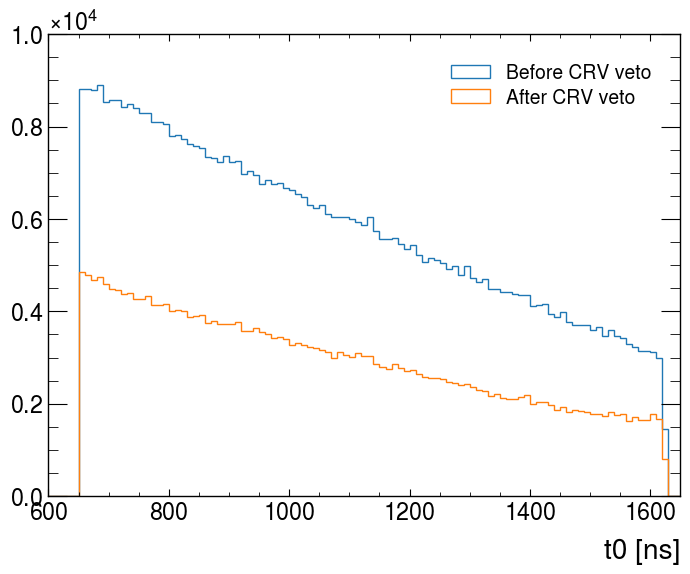

In [38]:
plt.hist(dfCE.query(cut_extmom+" & " + cut_t0+" & " + crv_live_window)['de_t0'], bins=110, range=(600, 1700), histtype='step', label='Before CRV veto');
plt.hist(dfCE.query(cut_current+" & " + cut_t0+" & " + crv_live_window)['de_t0'], bins=110, range=(600, 1700), histtype='step', label='After CRV veto');
plt.xlabel('t0 [ns]')
plt.xlim(600, 1650)
plt.legend();

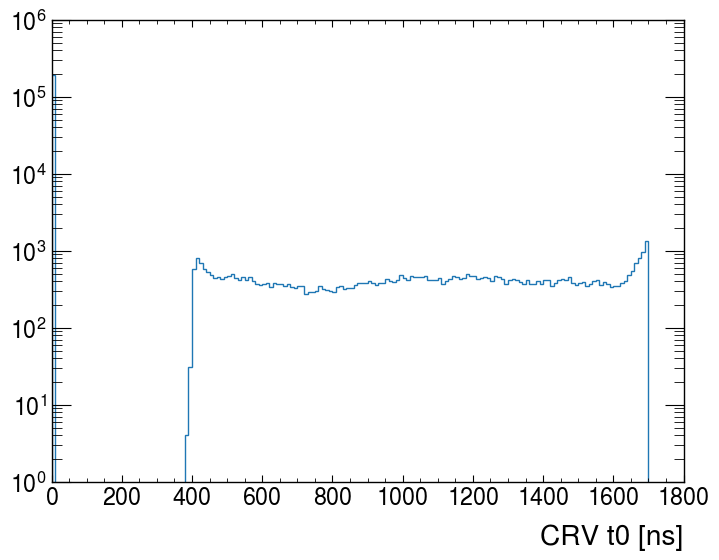

In [10]:
plt.hist(dfCE.query(cut_current+" & " + cut_t0)['crvinfo_timeWindowStart'], bins=170, range=(0, 1700), histtype='step', label='After CRV cuts');
plt.xlabel('CRV t0 [ns]')
plt.yscale('log')

In [40]:
cut_current

'(de_status > 0) & (deent_td > 0.577350) & (deent_td < 1.000) & (deent_d0 > -80) & (deent_d0 < 105) & (deent_maxr > 450) & (deent_maxr < 680) & (dequal_TrkQual > 0.8) & (dequal_TrkPID > 0.95) & (ue_status <= 0) & (deent_mom > 90.000000) & (deent_mom < 140.000000) & (de_t0 < crvinfo_timeWindowStart + -160 | de_t0 > crvinfo_timeWindowEnd + 140)'

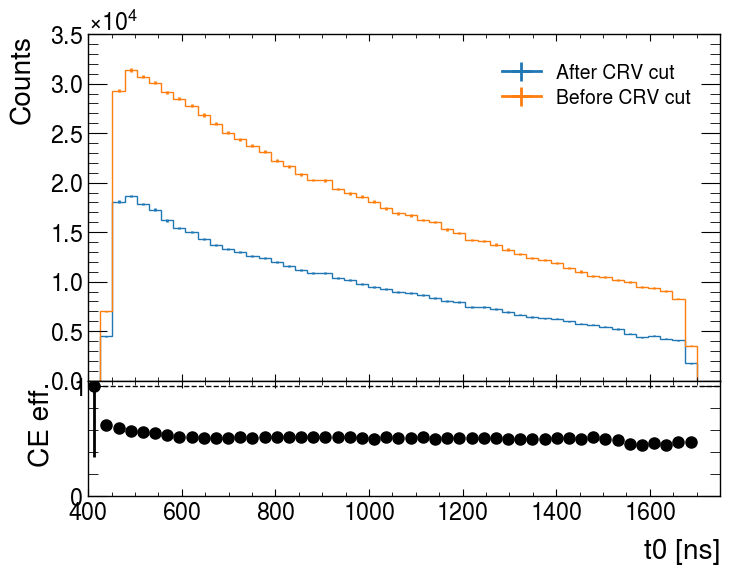

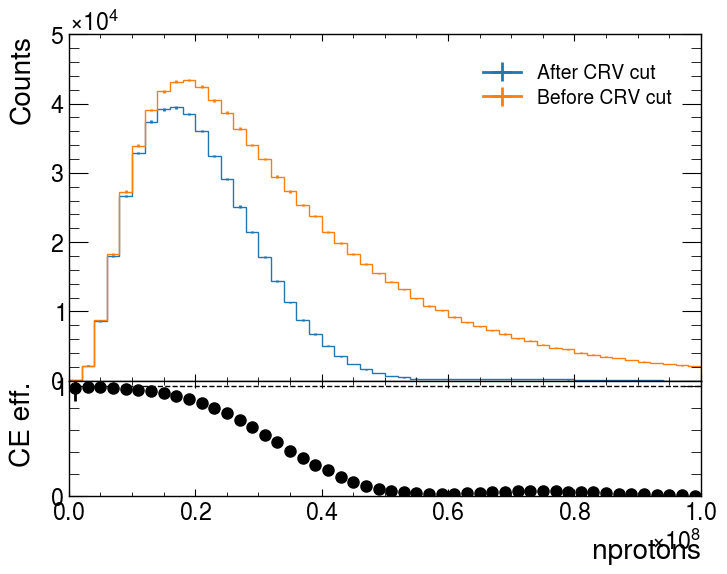

In [57]:
h = hist.Hist(
  hist.axis.StrCategory(["all", "cut", "all", "cut"], name="cat"),
  hist.axis.Regular(50, 400, 1700, name="x", label="t0 [ns]"),
  hist.storage.Weight(),
) 

h.fill(cat="all", x=dfCE.query(cut_extmom)['de_t0'].to_numpy())
h.fill(cat="cut", x=dfCE.query(cut_current)['de_t0'].to_numpy());

fig = plt.figure()
h["cut", :].plot_ratio(h["all", :], rp_num_label="After CRV cut", rp_denom_label="Before CRV cut", rp_ylim=[0.0, 1.05], rp_uncert_draw_type='line');
fig.get_axes()[1].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
fig.get_axes()[1].set_ylabel('CE eff.')
fig.get_axes()[1].set_xlim(400,1750)

h = hist.Hist(
  hist.axis.StrCategory(["all", "cut", "all", "cut"], name="cat"),
  hist.axis.Regular(50, 0, 1E8, name="x", label="nprotons"),
  hist.storage.Weight(),
) 

h.fill(cat="all", x=dfCE.query(cut_extmom)['evtinfomc_nprotons'].to_numpy())
h.fill(cat="cut", x=dfCE.query(cut_current)['evtinfomc_nprotons'].to_numpy());

fig = plt.figure()
h["cut", :].plot_ratio(h["all", :], rp_num_label="After CRV cut", rp_denom_label="Before CRV cut", rp_ylim=[0.0, 1.05], rp_uncert_draw_type='line');
fig.get_axes()[1].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
fig.get_axes()[1].set_ylabel('CE eff.');

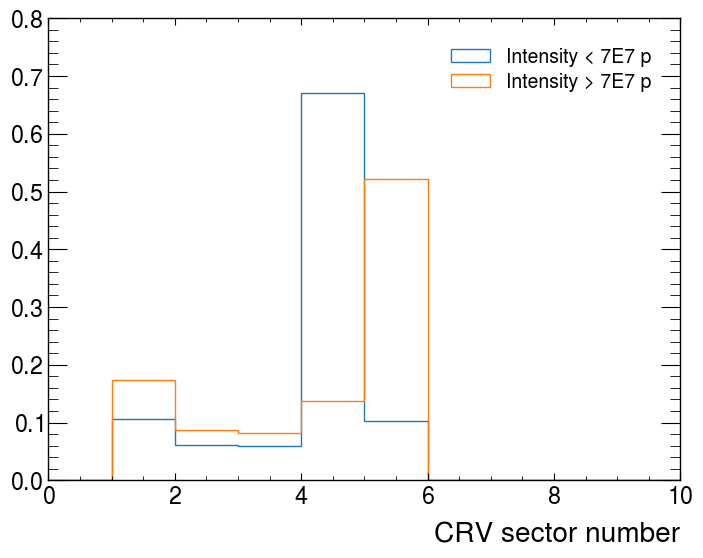

In [12]:
plt.hist(dfCE.query(cut_extmom+'&'+crv_time+'& evtinfomc_nprotons<7E7 & crvinfo_PEs>0')['crvinfo_crvSectorType'], bins=np.linspace(0, 10, 11), histtype='step', density=True, label='Intensity < 7E7 p') 
plt.hist(dfCE.query(cut_extmom+'&'+crv_time+'& evtinfomc_nprotons>7E7 & crvinfo_PEs>0')['crvinfo_crvSectorType'], bins=np.linspace(0, 10, 11), histtype='step', density=True, label='Intensity > 7E7 p')
plt.xlabel('CRV sector number')
plt.legend();

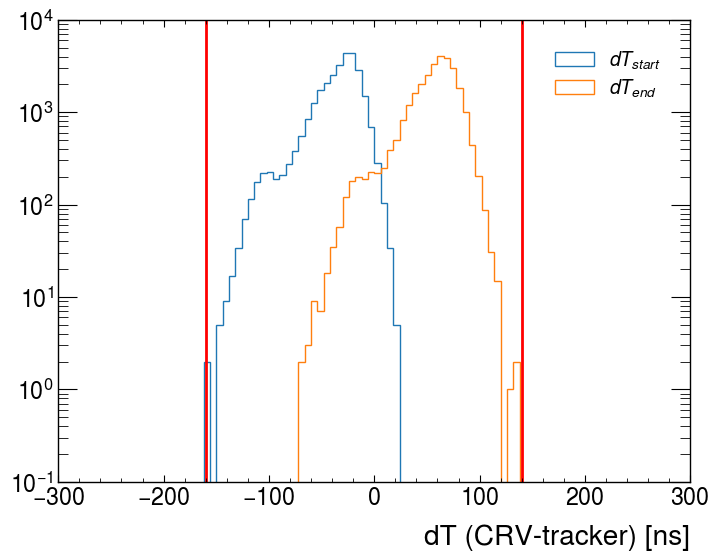

In [13]:
plt.hist(dfCRY5.query(cut_extmom+'& crvinfo_PEs>0')['crvinfo_dTs'], bins=100, range=(-300,300), histtype='step', label='$dT_{start}$');
plt.hist(dfCRY5.query(cut_extmom+'& crvinfo_PEs>0')['crvinfo_dTe'], bins=100, range=(-300,300), histtype='step', label='$dT_{end}$');
plt.axvline(x=140, color='red')
plt.axvline(x=-160, color='red')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xlabel('dT (CRV-tracker) [ns]');

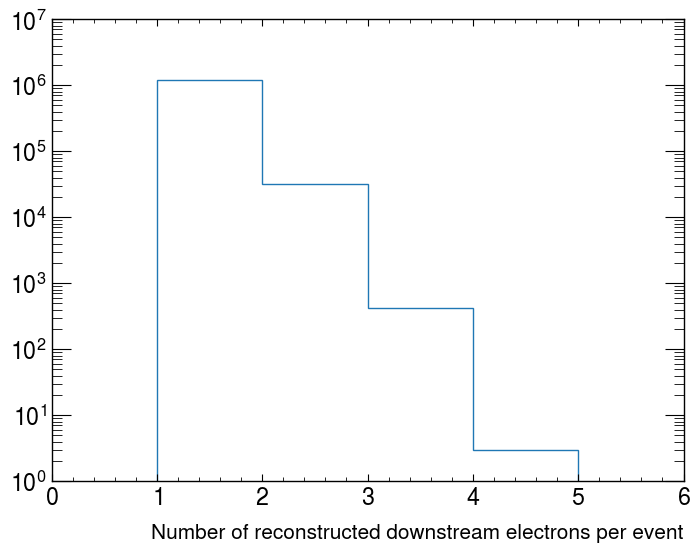

In [14]:
plt.hist(dfCE.groupby(['evtinfo_subrunid',	'evtinfo_eventid', 'evtinfomc_nprotons']).size().reset_index()[0], histtype='step', bins=6, range=(0,6));
plt.xlabel('Number of reconstructed downstream electrons per event', fontsize=15)
plt.yscale('log')

#PS sources at the end of micro-bunch

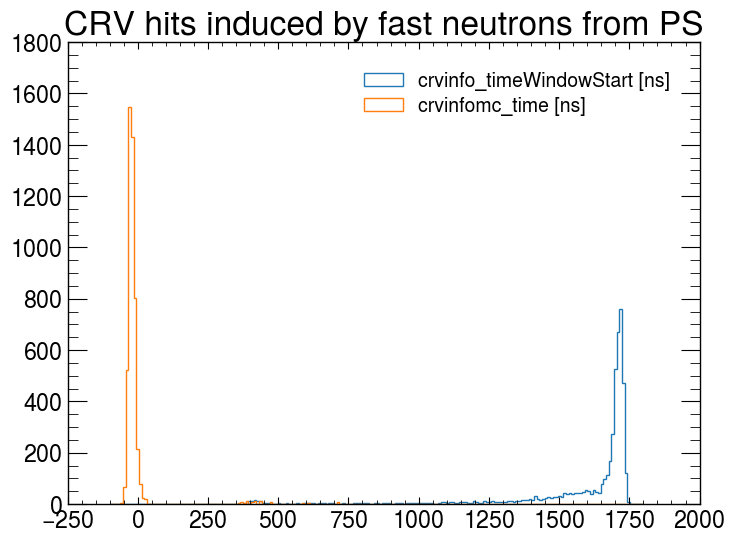

In [15]:
plt.hist(dfCE.query('crvinfomc_parentPdgId==2112 & crvinfomc_parentZ<-5000 &'+cut_t0)['crvinfo_timeWindowStart'], histtype='step', bins=200, range=(-100, 1800), label='crvinfo_timeWindowStart [ns]');
plt.hist(dfCE.query('crvinfomc_parentPdgId==2112 & crvinfomc_parentZ<-5000 &'+cut_t0)['crvinfomc_time'], histtype='step', bins=200, range=(-100, 1800), label='crvinfomc_time [ns]');
plt.title('CRV hits induced by fast neutrons from PS')
plt.legend();

Text(0.5, 1.0, 'CRY')

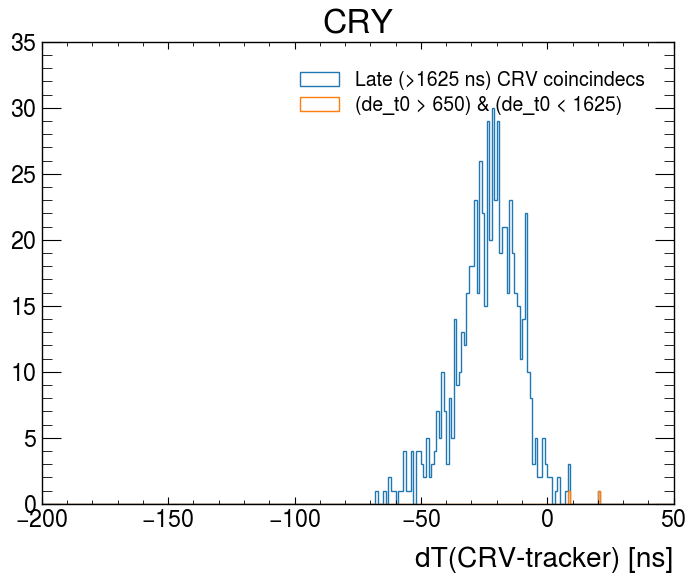

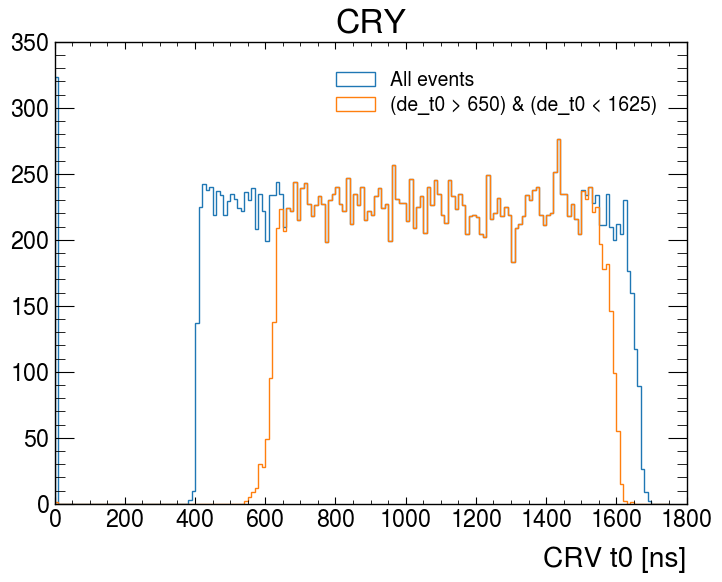

In [16]:
cut_tmp=cut_extmom_notiming+'& crvsummarymc_z>-9999'
plt.hist(dfCRY5.query(cut_tmp+'& crvinfo_timeWindowStart>1625')['crvinfo_dT'], histtype='step', bins=250, range=(-200, 50), label='Late (>1625 ns) CRV coincindecs');
plt.hist(dfCRY5.query(cut_tmp+'& crvinfo_timeWindowStart>1625'+'&'+cut_t0)['crvinfo_dT'], histtype='step', bins=250, range=(-200, 50), label=cut_t0);
plt.title('CRY')
plt.legend()
plt.xlabel('dT(CRV-tracker) [ns]')

plt.figure()
plt.hist(dfCRY5.query(cut_tmp)['crvinfo_timeWindowStart'], histtype='step', bins=175, range=(0, 1750), label='All events');
plt.hist(dfCRY5.query(cut_tmp+'&'+cut_t0)['crvinfo_timeWindowStart'], histtype='step', bins=175, range=(0, 1750), label=cut_t0);
plt.legend()
plt.xlabel('CRV t0 [ns]')
plt.title('CRY')

#Oversampling factor

In [17]:
df_tmp = dfCE.query('crvinfo_PEs>0 & '+ cut_t0).groupby(['crvinfomc_x',	'crvinfomc_y', 'crvinfomc_z', 'crvinfomc_parentX', 'crvinfomc_parentZ', 'crvinfomc_parentPdgId', 'crvinfomc_gparentX', 'crvinfomc_gparentZ', 'crvinfomc_gparentPdgId', 'crvinfomc_pdgId', 'crvinfomc_time']).size().reset_index()
df_tmp.rename(columns={0:'sampling_factor'}, inplace=True)

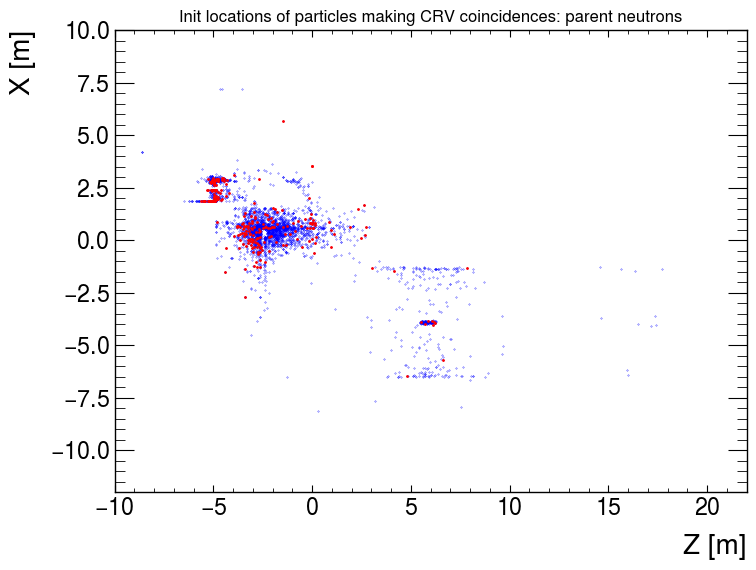

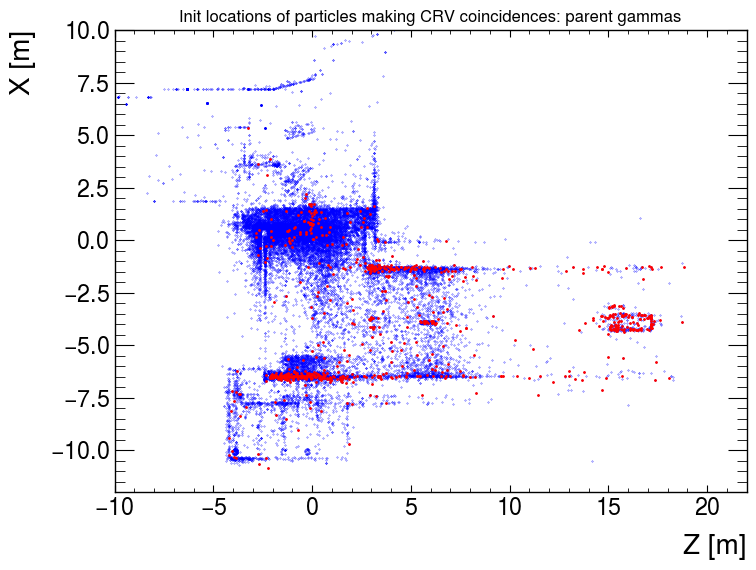

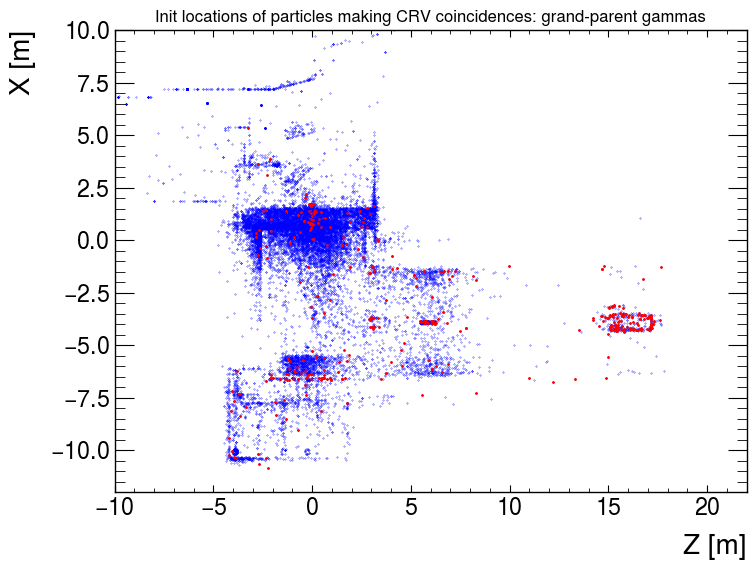

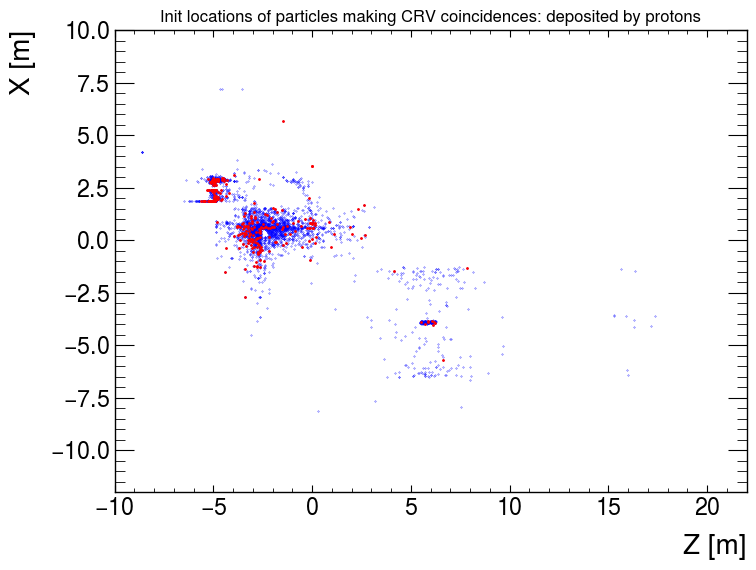

In [18]:
df_tmp2 = df_tmp.query('crvinfomc_parentPdgId==2112 & sampling_factor>1 & crvinfomc_time>-100')
plt.plot(df_tmp2['crvinfomc_parentZ']/1000, df_tmp2['crvinfomc_parentX']/1000, '.b', markersize=0.5);
df_tmp2 = df_tmp.query('crvinfomc_parentPdgId==2112 & sampling_factor>10 & crvinfomc_time>-100')
plt.plot(df_tmp2['crvinfomc_parentZ']/1000, df_tmp2['crvinfomc_parentX']/1000, '.r', markersize=2.0);
plt.ylim(-12, 10)
plt.xlim(-10, 22)
plt.title('Init locations of particles making CRV coincidences: parent neutrons', fontsize=12)
plt.xlabel('Z [m]')
plt.ylabel('X [m]')

plt.figure()
df_tmp2 = df_tmp.query('crvinfomc_parentPdgId==22 & sampling_factor>1')
plt.plot(df_tmp2['crvinfomc_parentZ']/1000, df_tmp2['crvinfomc_parentX']/1000, '.b', markersize=0.5);
df_tmp2 = df_tmp.query('crvinfomc_parentPdgId==22 & sampling_factor>10')
plt.plot(df_tmp2['crvinfomc_parentZ']/1000, df_tmp2['crvinfomc_parentX']/1000, '.r', markersize=2.0);
plt.ylim(-12, 10)
plt.xlim(-10, 22)
plt.title('Init locations of particles making CRV coincidences: parent gammas', fontsize=12)
plt.xlabel('Z [m]')
plt.ylabel('X [m]')

plt.figure()
df_tmp2 = df_tmp.query('crvinfomc_gparentPdgId==22 & sampling_factor>1')
plt.plot(df_tmp2['crvinfomc_gparentZ']/1000, df_tmp2['crvinfomc_gparentX']/1000, '.b', markersize=0.5);
df_tmp2 = df_tmp.query('crvinfomc_gparentPdgId==22 & sampling_factor>10')
plt.plot(df_tmp2['crvinfomc_gparentZ']/1000, df_tmp2['crvinfomc_gparentX']/1000, '.r', markersize=2.0);
plt.ylim(-12, 10)
plt.xlim(-10, 22)
plt.title('Init locations of particles making CRV coincidences: grand-parent gammas', fontsize=12)
plt.xlabel('Z [m]')
plt.ylabel('X [m]')

plt.figure()
df_tmp2 = df_tmp.query('crvinfomc_pdgId==2212 & sampling_factor>1')
plt.plot(df_tmp2['crvinfomc_gparentZ']/1000, df_tmp2['crvinfomc_gparentX']/1000, '.b', markersize=0.5);
df_tmp2 = df_tmp.query('crvinfomc_pdgId==2212 & sampling_factor>10')
plt.plot(df_tmp2['crvinfomc_gparentZ']/1000, df_tmp2['crvinfomc_gparentX']/1000, '.r', markersize=2.0);
plt.ylim(-12, 10)
plt.xlim(-10, 22)
plt.title('Init locations of particles making CRV coincidences: deposited by protons', fontsize=12)
plt.xlabel('Z [m]')
plt.ylabel('X [m]');

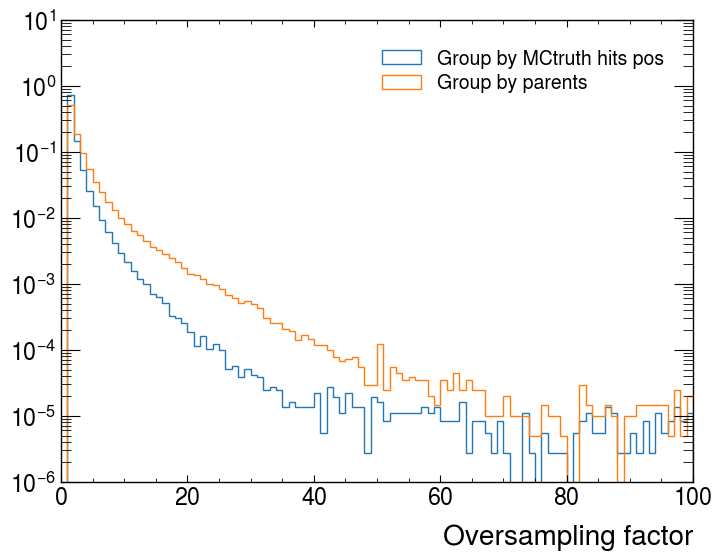

In [19]:
df_tmp = dfCE.query('crvinfo_PEs>0 & '+ cut_t0).groupby(['crvinfomc_x',	'crvinfomc_y', 'crvinfomc_z']).size().reset_index()
df_tmp.rename(columns={0:'sampling_factor'}, inplace=True)
plt.hist(df_tmp['sampling_factor'], histtype='step', density=True, bins=100, range=(0, 100), label='Group by MCtruth hits pos');

df_tmp = dfCE.query('crvinfo_PEs>0 & '+ cut_t0).groupby(['crvinfomc_parentX',	'crvinfomc_parentY', 'crvinfomc_parentZ']).size().reset_index()
df_tmp.rename(columns={0:'sampling_factor'}, inplace=True)
plt.hist(df_tmp['sampling_factor'], histtype='step', density=True, bins=100, range=(0, 100), label='Group by parents');

plt.xlabel('Oversampling factor');
plt.legend()
plt.yscale('log')

#Coincidence sources

<Figure size 800x600 with 0 Axes>

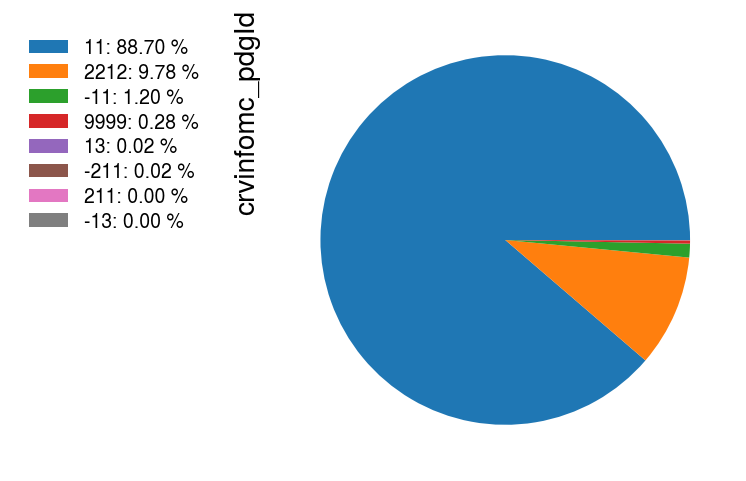

<Figure size 800x600 with 0 Axes>

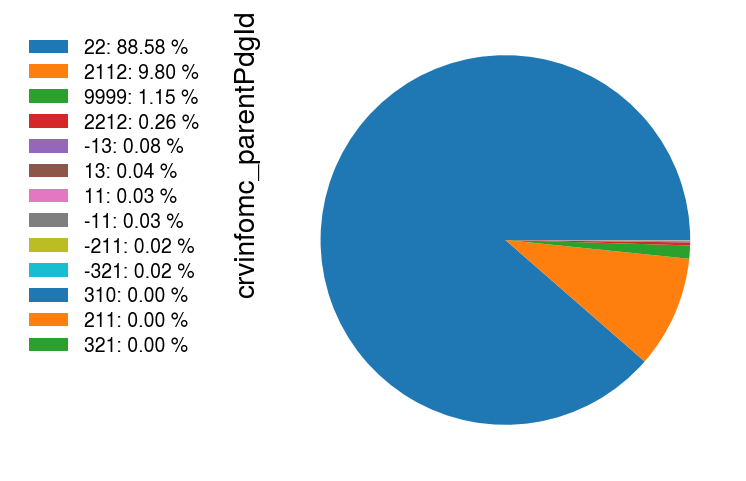

<Figure size 800x600 with 0 Axes>

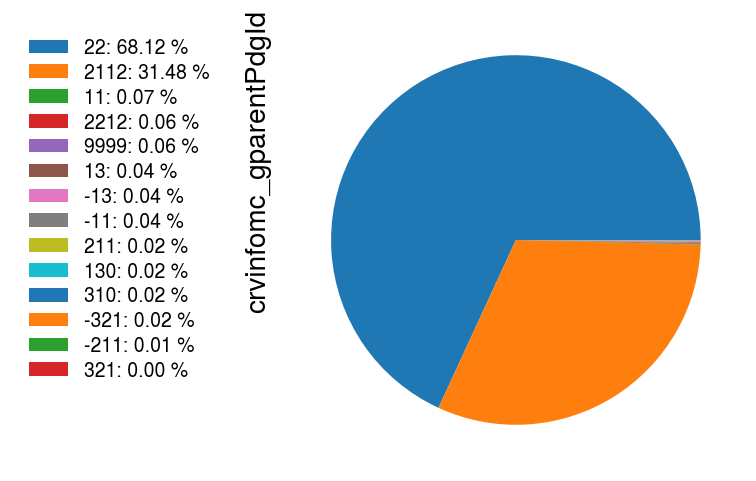

In [20]:
def plot_pie(var):
  plt.figure()
  df_tmp = dfCE.query('crvinfo_PEs>0')[var].clip(upper=9999).to_frame()
  df_tmp = df_tmp.groupby([var]).size().to_frame().reset_index()
  df_tmp.rename(columns={0:'counts'}, inplace=True)
  df_tmp.sort_values('counts', inplace=True, ascending=False)

  df_tmp.plot(kind='pie', y='counts', labels=None)
  plt.ylabel(var)

  # Calculate percentages
  percent = 100.*df_tmp.counts/df_tmp.counts.sum()
  # Write labels
  labels = ['{0}: {1:1.2f} %'.format(i,j) for i,j in zip(df_tmp[var], percent)]
  plt.legend(labels, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=14);

plot_pie('crvinfomc_pdgId')
plot_pie('crvinfomc_parentPdgId')
plot_pie('crvinfomc_gparentPdgId')

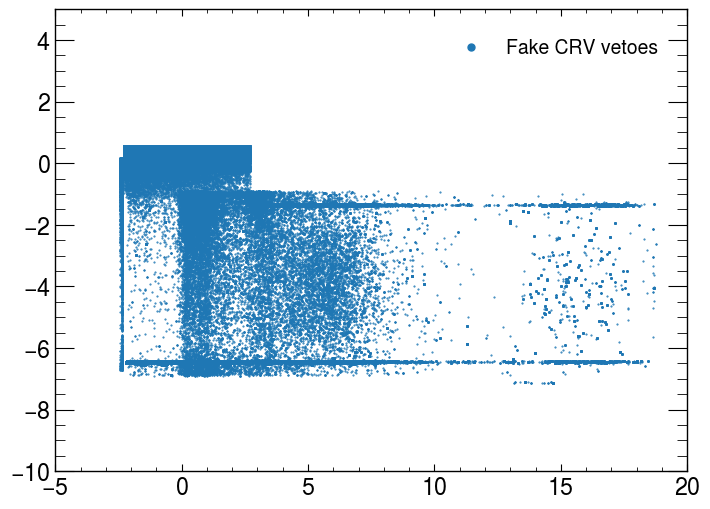

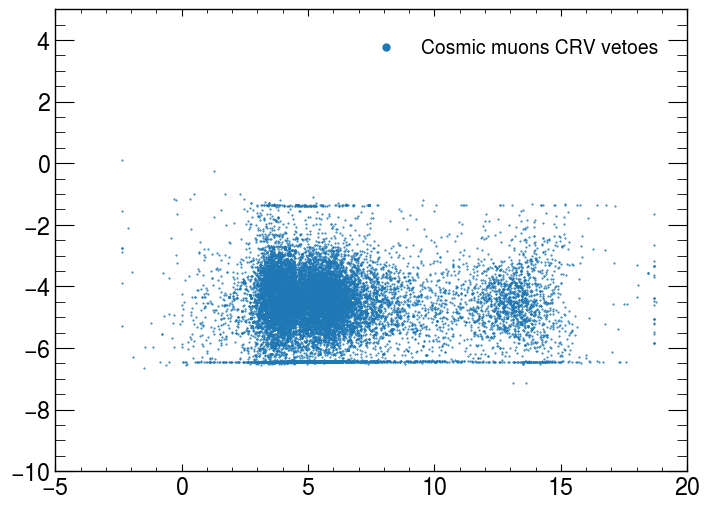

In [21]:
plt.plot(dfCE.query(cut_extmom)['crvsummarymc_z']/1000, dfCE.query(cut_extmom)['crvsummarymc_x']/1000, '.', label='Fake CRV vetoes', markersize=1.0)
plt.xlim(-5,20)
plt.ylim(-10,5)
plt.legend();
lgnd = plt.legend()
lgnd.legendHandles[0].set_markersize(10)

plt.figure()
plt.plot(dfCRY5.query(cut_extmom)['crvsummarymc_z']/1000, dfCRY5.query(cut_extmom)['crvsummarymc_x']/1000, '.', label='Cosmic muons CRV vetoes', markersize=1.)
plt.xlim(-5,20)
plt.ylim(-10,5)
plt.legend();
lgnd = plt.legend()
lgnd.legendHandles[0].set_markersize(10)

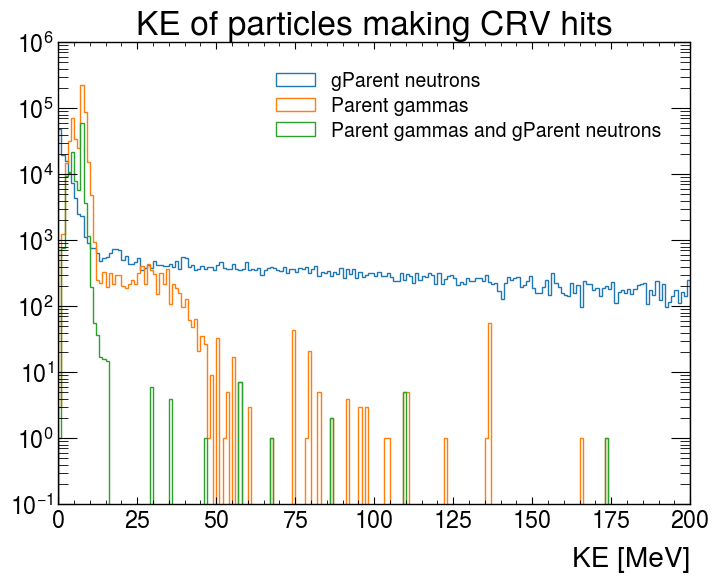

In [22]:
plt.hist(dfCE.query(cut_extmom+'& crvinfomc_gparentPdgId==2112')['crvinfomc_gparentE'], range=(0, 200), bins=200, histtype='step', label='gParent neutrons');
plt.hist(dfCE.query(cut_extmom+'& crvinfomc_parentPdgId==22')['crvinfomc_parentE'], range=(0, 200), bins=200, histtype='step', label='Parent gammas');
plt.hist(dfCE.query(cut_extmom+'& crvinfomc_parentPdgId==22 & crvinfomc_gparentPdgId==2112')['crvinfomc_parentE'], range=(0, 200), bins=200, histtype='step', label='Parent gammas and gParent neutrons');
plt.xlabel('KE [MeV]')
plt.title('KE of particles making CRV hits')
plt.legend()
plt.yscale('log')

Text(0.5, 1.0, 'Origins of cosmics')

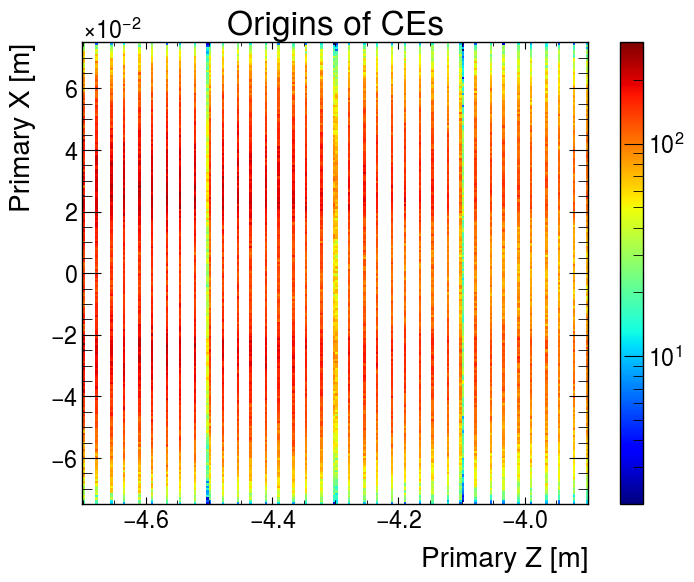

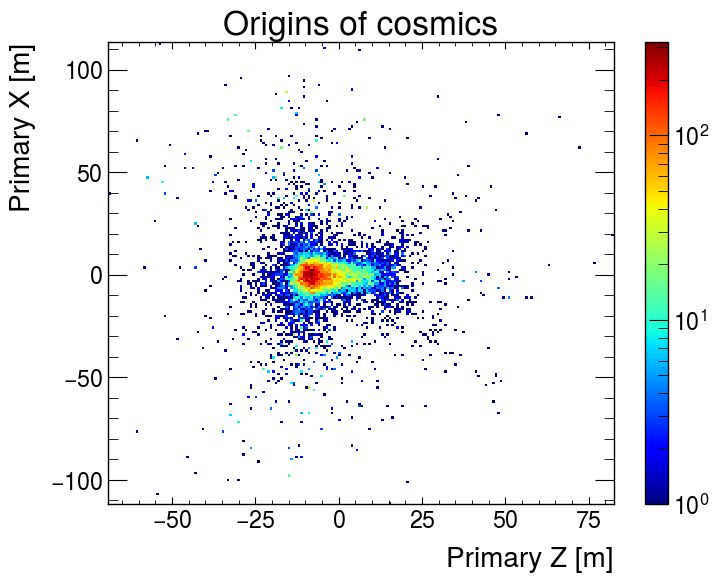

In [23]:
h=plt.hist2d(dfCE.query(cut_extmom)['demcpri_posZ']/1000, dfCE.query(cut_extmom)['demcpri_posX']/1000, bins = 200, norm=mpl.colors.LogNorm(), cmap=plt.cm.jet);
plt.colorbar(h[3])
plt.xlabel('Primary Z [m]')
plt.ylabel('Primary X [m]');
plt.title('Origins of CEs')

plt.figure()
h=plt.hist2d(dfCRY5.query(cut_extmom)['demcpri_posZ']/1000, dfCRY5.query(cut_extmom)['demcpri_posX']/1000, bins = 200, norm=mpl.colors.LogNorm(), cmap=plt.cm.jet);
plt.colorbar(h[3])
plt.xlabel('Primary Z [m]')
plt.ylabel('Primary X [m]');
plt.title('Origins of cosmics')

#Variables to discriminate noise from cosmics

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:6607: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:6608: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


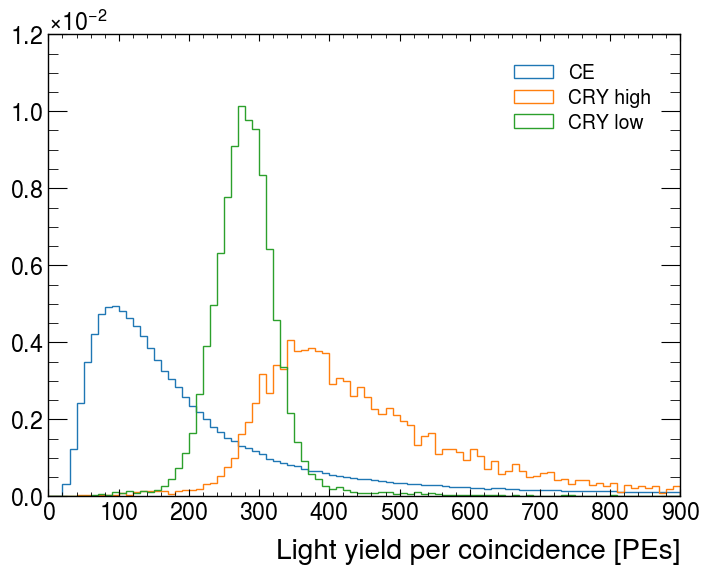

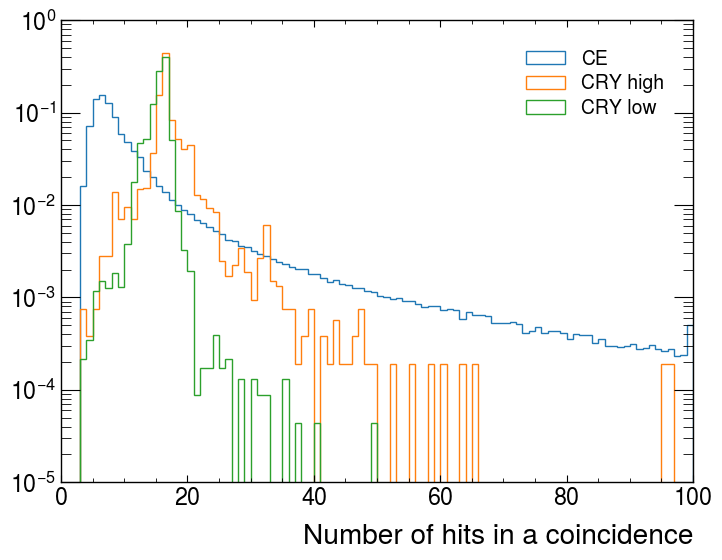

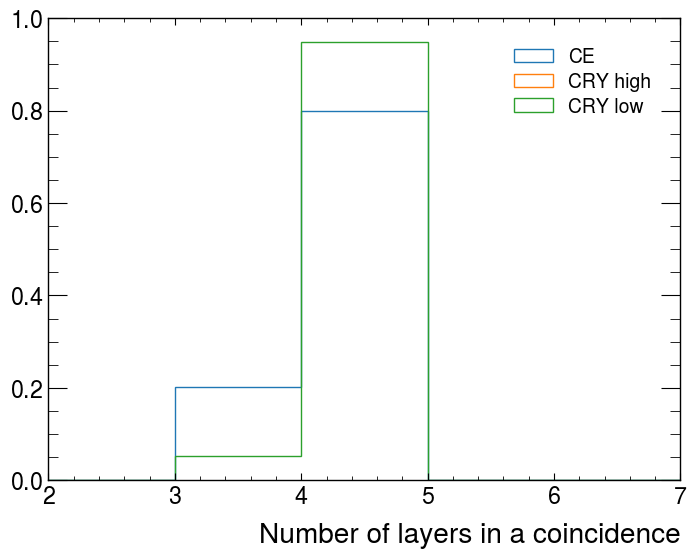

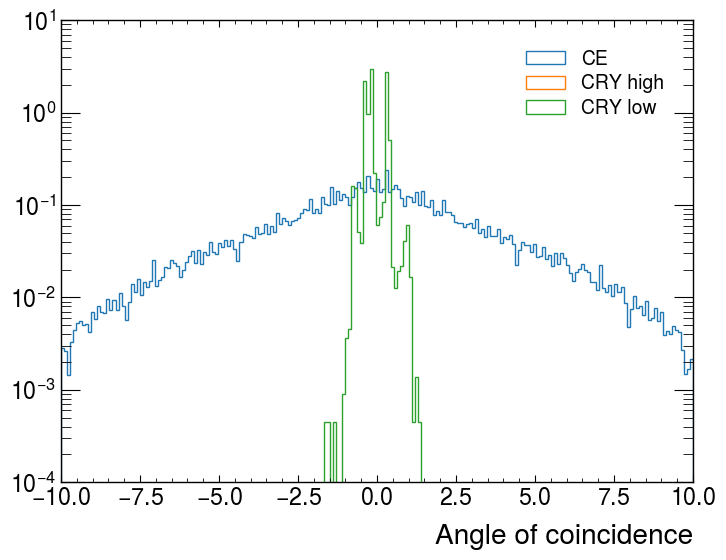

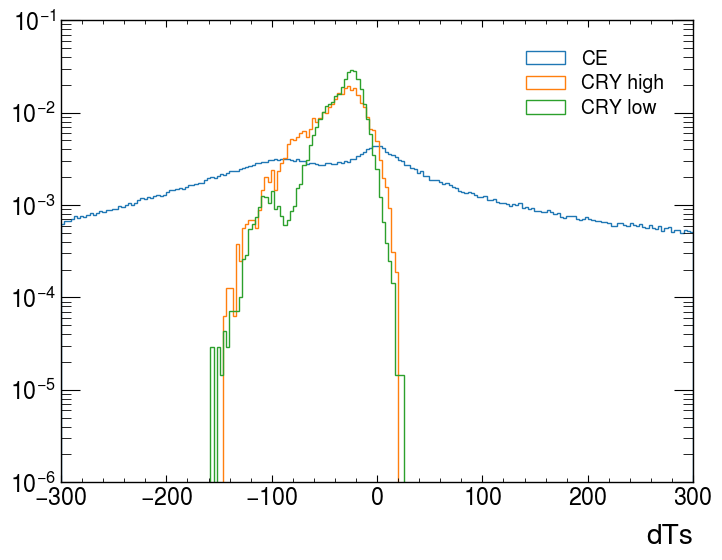

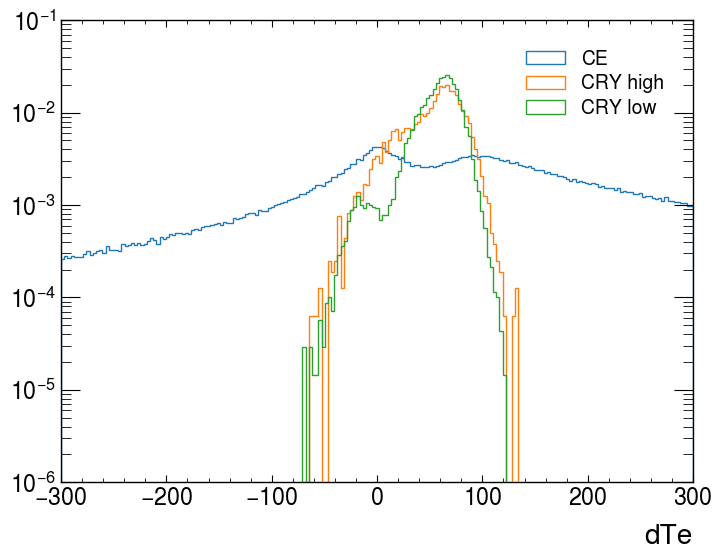

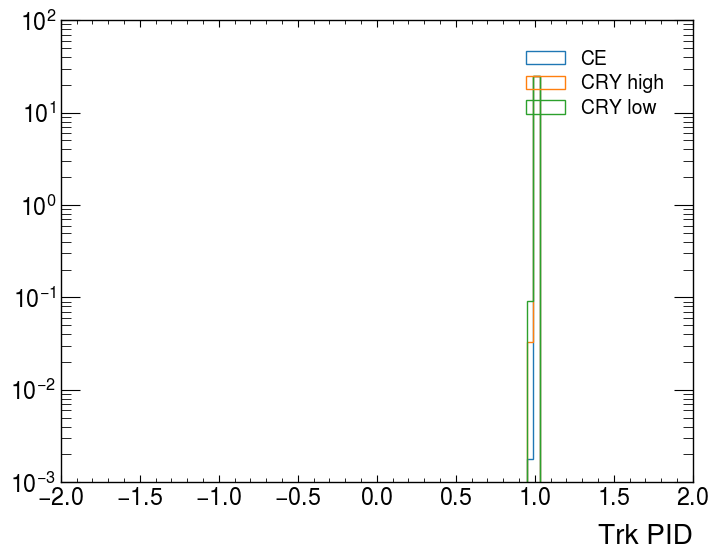

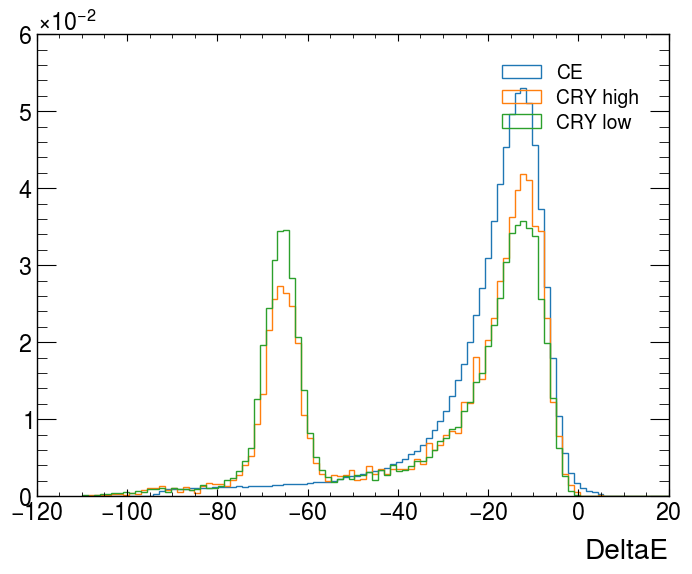

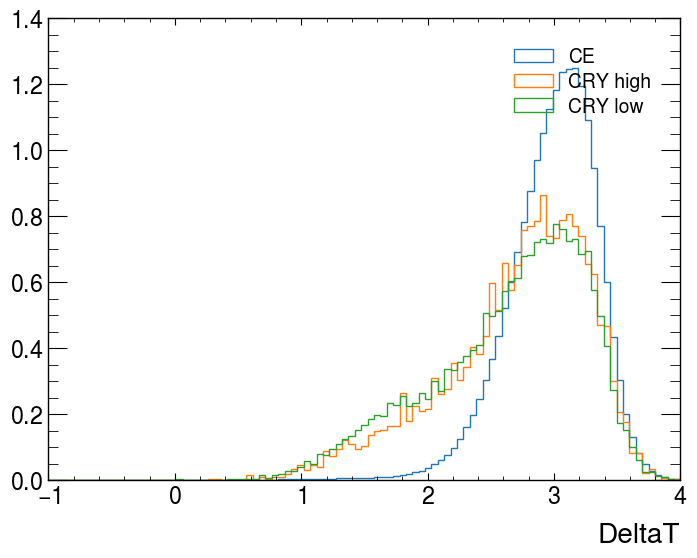

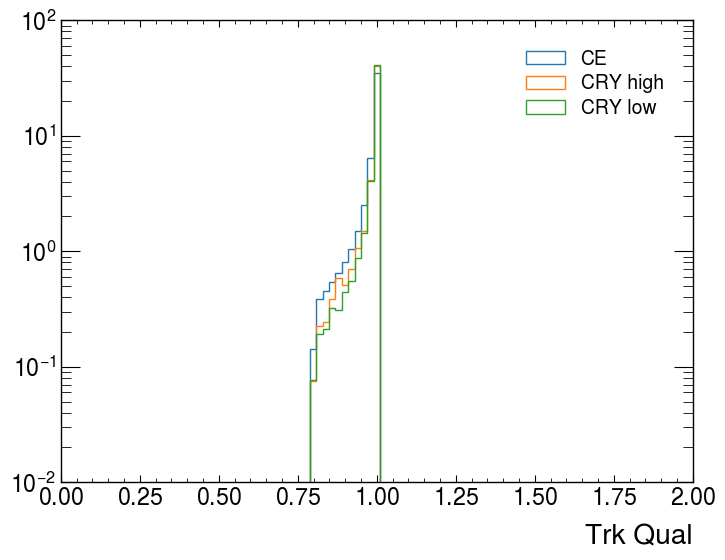

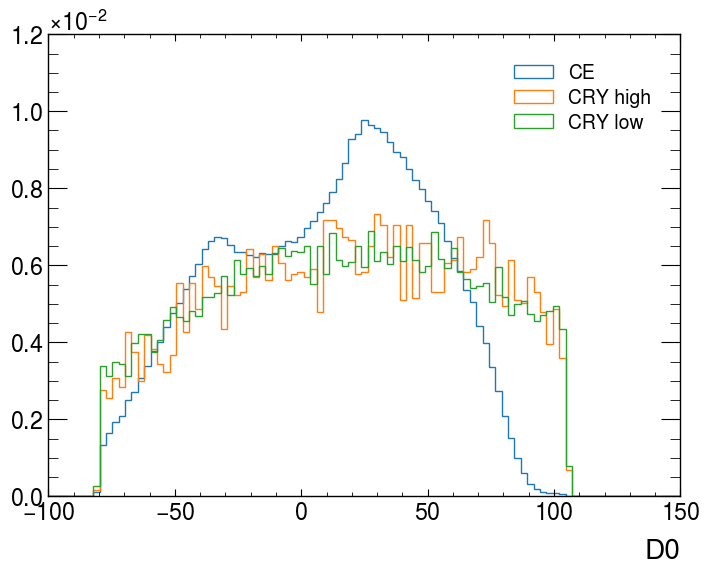

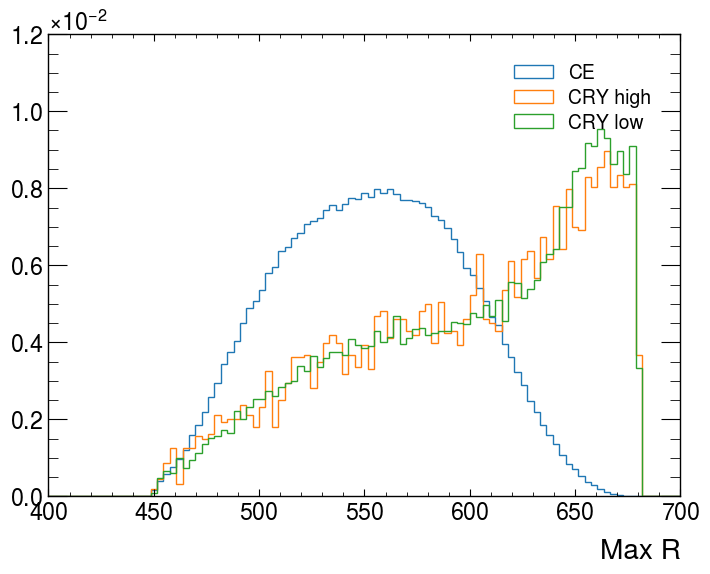

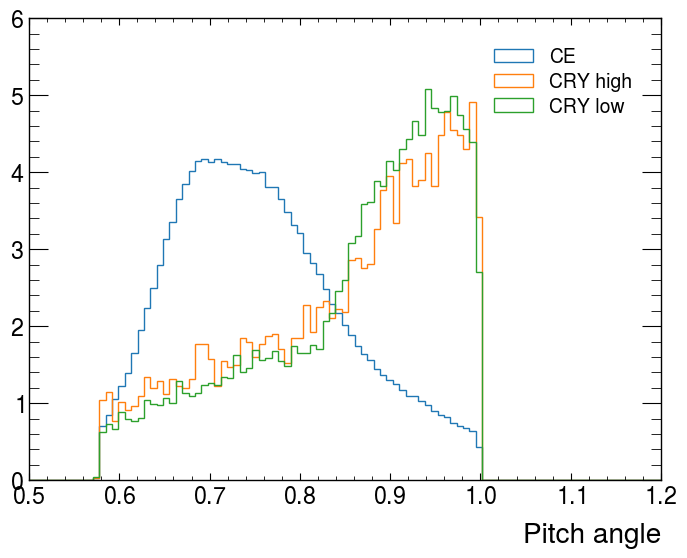

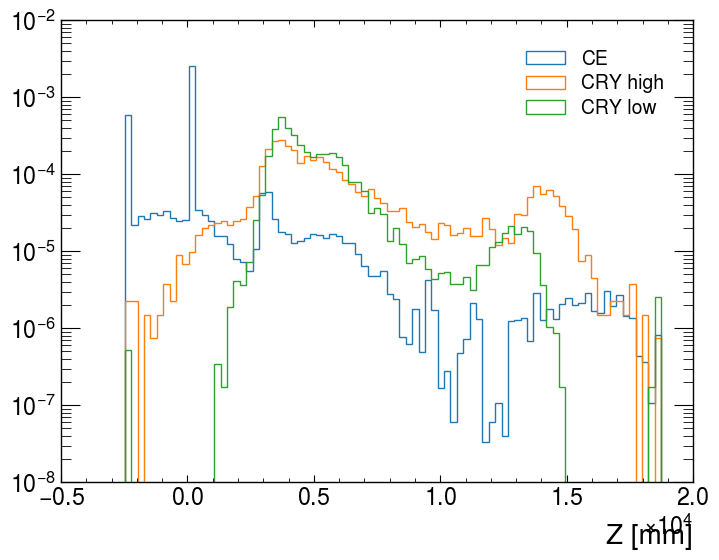

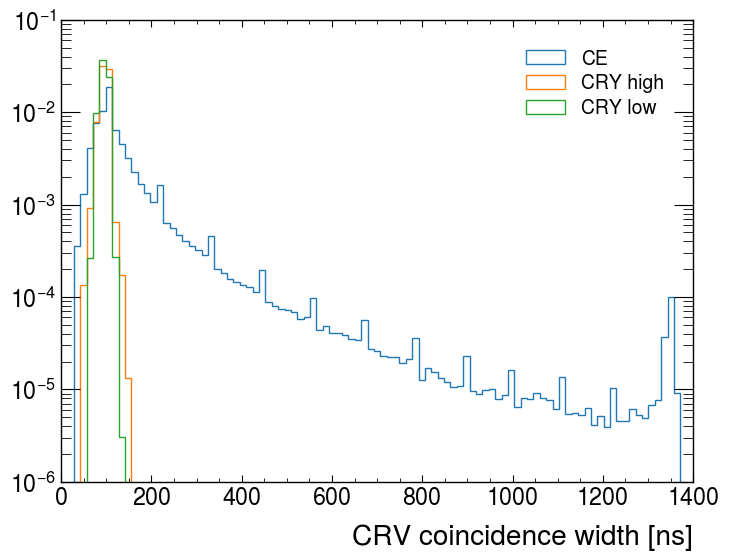

In [24]:
def compare_hist(var, bins, xlabel, logy=False):
  plt.figure()
  plt.hist(dfCE.query(cut_extmom+'& crvinfo_PEs>0')[var], bins=bins, histtype='step', label='CE', density=True);
  plt.hist(dfCRY5.query(cut_extmom+'& is_high==1 & crvinfo_PEs>0')[var], bins=bins, histtype='step', label='CRY high', density=True);
  plt.hist(dfCRY5.query(cut_extmom+'& is_high==0 & crvinfo_PEs>0')[var], bins=bins, histtype='step', label='CRY low', density=True);
  if logy:
    plt.yscale('log')
  plt.xlabel(xlabel)
  plt.legend();

compare_hist('crvinfo_PEs', np.linspace(0, 900, 91), 'Light yield per coincidence [PEs]')
compare_hist('crvinfo_nCoincidenceHits', np.linspace(0, 100, 101), 'Number of hits in a coincidence', True)
compare_hist('crvinfo_nCoincidenceLayers', np.linspace(2, 7, 6), 'Number of layers in a coincidence')
compare_hist('crvinfo_angle', np.linspace(-10, 10, 210), 'Angle of coincidence', True)
compare_hist('crvinfo_dTs', np.linspace(-300, 300, 200), 'dTs', True)
compare_hist('crvinfo_dTe', np.linspace(-300, 300, 200), 'dTe', True)
compare_hist('dequal_TrkPID', np.linspace(-2, 2, 100), 'Trk PID', True)
compare_hist('detrkpid_DeltaE', np.linspace(-110, 20, 100), 'DeltaE')
compare_hist('detrkpid_DeltaT', np.linspace(-1, 4, 100), 'DeltaT')

compare_hist('dequal_TrkQual', np.linspace(0, 2, 100), 'Trk Qual', True)
compare_hist('deent_d0', np.linspace(-100, 150, 100), 'D0')
compare_hist('deent_maxr', np.linspace(400, 700, 100), 'Max R')
compare_hist('deent_td', np.linspace(0.5, 1.2, 100), 'Pitch angle')
compare_hist('crvinfo_z', np.linspace(-5000, 20000, 100), 'Z [mm]', True)


dfCRY5['crvinfo_windowSize'] = dfCRY5['crvinfo_timeWindowEnd'] - dfCRY5['crvinfo_timeWindowStart']
dfCE['crvinfo_windowSize'] = dfCE['crvinfo_timeWindowEnd'] - dfCE['crvinfo_timeWindowStart']
compare_hist('crvinfo_windowSize', np.linspace(0, 1400, 100), 'CRV coincidence width [ns]', True)


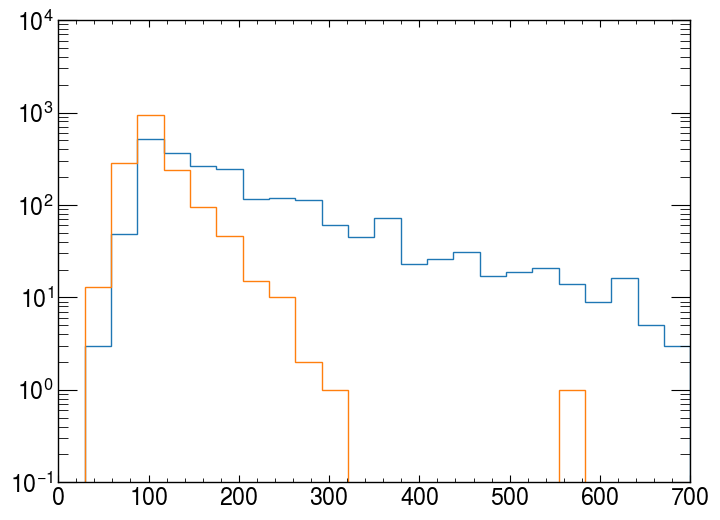

In [25]:
df_tmp = dfCE.query(cut_extmom+'&'+crv_time+'& evtinfomc_nprotons>5E7 & crvinfo_crvSectorType==4').groupby(['evtinfo_eventid','evtinfo_subrunid'])['crvinfo_windowSize'].agg('sum')
plt.hist(df_tmp.reset_index()['crvinfo_windowSize'], histtype='step', bins=np.linspace(0,700, 25));
df_tmp = dfCE.query(cut_extmom+'&'+crv_time+'& evtinfomc_nprotons>5E7 & crvinfo_crvSectorType==5').groupby(['evtinfo_eventid','evtinfo_subrunid'])['crvinfo_windowSize'].agg('sum')
plt.hist(df_tmp.reset_index()['crvinfo_windowSize'], histtype='step', bins=np.linspace(0,700, 25));
plt.yscale('log')

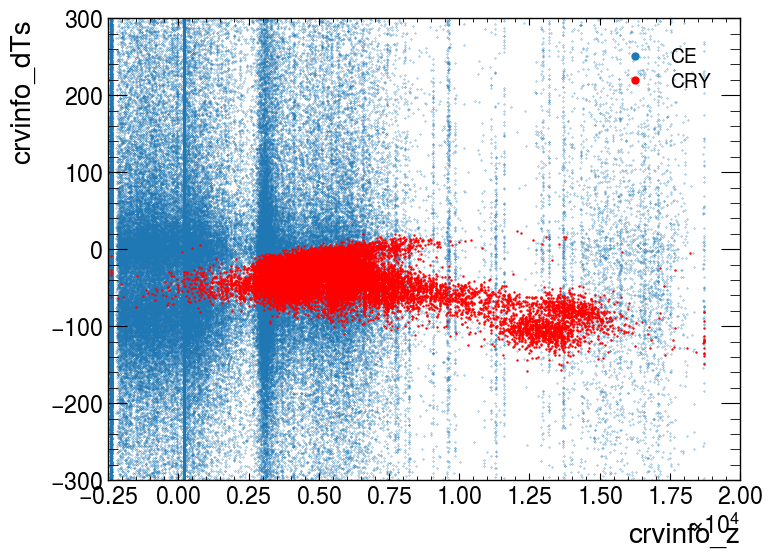

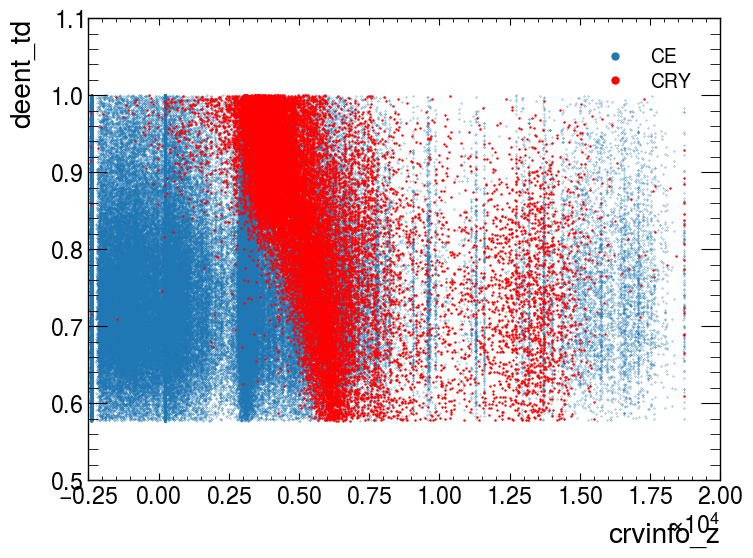

In [47]:
def compare_plot(var1, var2, rangeX=None, rangeY=None):
  plt.figure()
  plt.plot(dfCE.query(cut_extmom+'& crvinfo_PEs>0')[var1], dfCE.query(cut_extmom+'& crvinfo_PEs>0')[var2],  '.', label='CE', markersize=0.5);
  plt.plot(dfCRY5.query(cut_extmom+'& crvinfo_PEs>0')[var1], dfCRY5.query(cut_extmom+'& crvinfo_PEs>0')[var2],  '.r', label='CRY', markersize=1.5);
  if rangeY is not None:
    plt.ylim(rangeY)
  if rangeX is not None:
    plt.xlim(rangeX)
  plt.xlabel(var1)
  plt.ylabel(var2)
  lgnd = plt.legend()
  lgnd.legendHandles[0].set_markersize(10)
  lgnd.legendHandles[1].set_markersize(10)

compare_plot('crvinfo_z', 'crvinfo_dTs', rangeY=(-300, 300))
compare_plot('crvinfo_z', 'deent_td');


#Calo variables

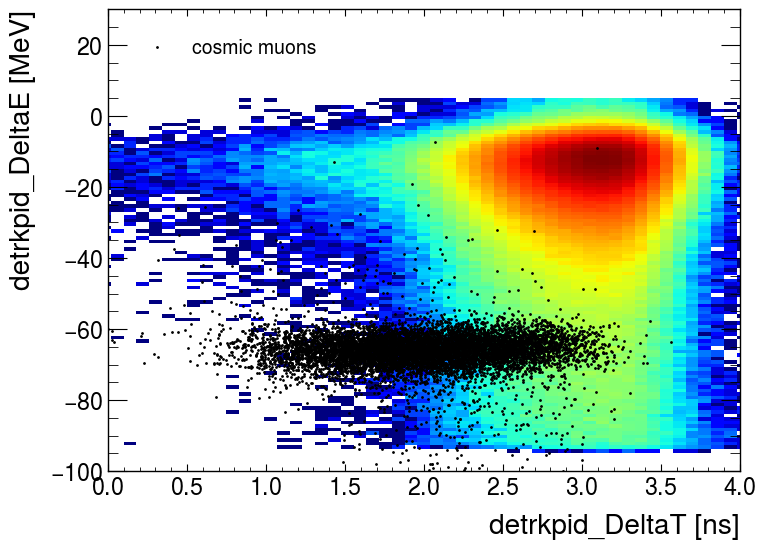

In [27]:
cut_tmp = cut_extmom+'& abs(demc_pdg) == 11'
plt.hist2d(dfCE.query(cut_tmp)['detrkpid_DeltaT'], dfCE.query(cut_tmp)['detrkpid_DeltaE'], bins = 100, norm=mpl.colors.LogNorm(), cmap=plt.cm.jet, label='CE');
cut_tmp = cut_extmom+'& abs(demc_pdg) == 13'
plt.plot(dfCRY5.query(cut_tmp)['detrkpid_DeltaT'], dfCRY5.query(cut_tmp)['detrkpid_DeltaE'], '.k', markersize='2.0', label='cosmic muons');

plt.xlabel('detrkpid_DeltaT [ns]')
plt.ylabel('detrkpid_DeltaE [MeV]')
plt.xlim(0,4)
plt.ylim(-100,30);
plt.legend(loc='upper left');

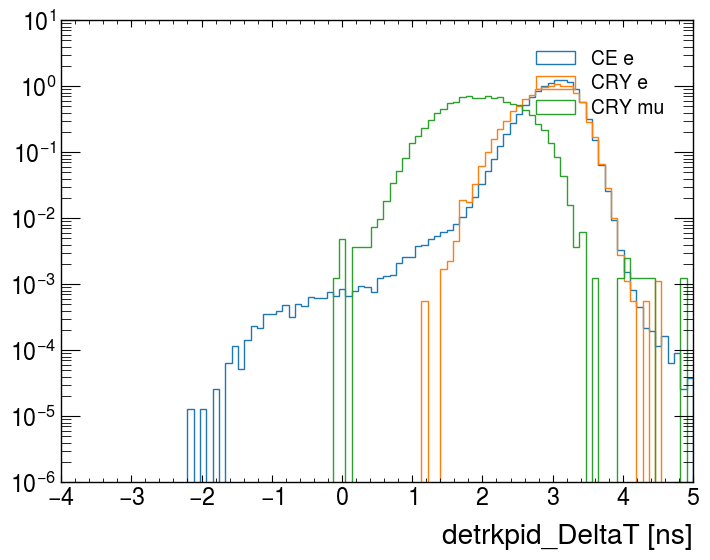

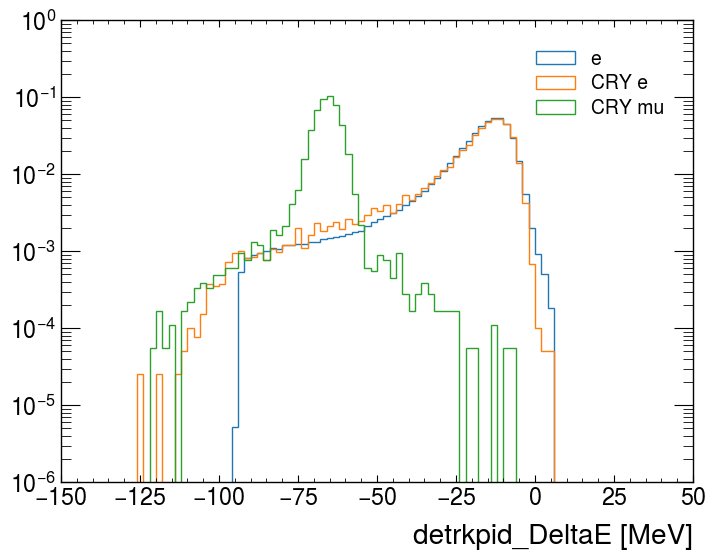

In [28]:
plt.figure()
plt.hist(dfCE.query(cut_extmom+'& abs(demc_pdg) == 11')['detrkpid_DeltaT'], bins = 100, range=(-4,5), histtype='step', label='CE e', density=True);
plt.hist(dfCRY5.query(cut_extmom+'& abs(demc_pdg) == 11')['detrkpid_DeltaT'], bins = 100, range=(-4,5), histtype='step', label='CRY e', density=True);
plt.hist(dfCRY5.query(cut_extmom+'& abs(demc_pdg) == 13')['detrkpid_DeltaT'], bins = 100, range=(-4,5), histtype='step', label='CRY mu', density=True);
plt.xlabel('detrkpid_DeltaT [ns]')
plt.yscale('log')
plt.legend()

plt.figure()
plt.hist(dfCE.query(cut_extmom+'& abs(demc_pdg) == 11 ')['detrkpid_DeltaE'], bins = 100, range=(-150,50), histtype='step', label='e', density=True);
plt.hist(dfCRY5.query(cut_extmom+'& abs(demc_pdg) == 11')['detrkpid_DeltaE'], bins = 100, range=(-150,50), histtype='step', label='CRY e', density=True);
plt.hist(dfCRY5.query(cut_extmom+'& abs(demc_pdg) == 13')['detrkpid_DeltaE'], bins = 100, range=(-150,50), histtype='step', label='CRY mu', density=True);
plt.xlabel('detrkpid_DeltaE [MeV]')
plt.yscale('log')
plt.legend();